# Tabular model

This notebook will explain the process to refine the MLP model trained with tabular data and it's explanations

In [ ]:
from IPython.display import Image, display

# First approach


In this first approach, I trained the model with all the features available in the dataset. At first, I processed the dataset with dummy encoding. This created artificial columns like "Signs_no" or "Signs_yes", which was not very usable.

For that reason, I decided to encode the columns properly by assigning a numerical value to the columns in the dataset. For example, in the column shape with values "Oval", "Sphere" and "Irregular", "oval" would be translated as 0, "Sphere" as 1 and "Irregular" as 2.

There was no noticeable difference in accuracy in either of the approaches described above. For that reason, I kept using the second one.

I trained the model using 
```bash
python -m src.train_tabular
```

with the following hyperparameters defined in the same file:

> epochs: int = 40  
> lr: float = 1e-4  
> batch_size: int = 8  
> dropout: float = 0.2  
> hidden_dims: list = (128, 256)  
> use_encoding: bool = True  
> drop_columns: bool = False  
> custom_weights: bool = False  
> malignant_penalty: float = 1  

The results were:

> **Train Accuracy:**   89.71%  
> **Val Accuracy:**  84.62%  
> **Test Accuracy:**  88.46%  


At this point, I tried to explain the model using permutation importance and SHAP to try and remove unnecesary features. To explain the tabular model, I executed:

```bash
python -m src.explain_tabular
```

adjusting the hyperparameters in the file accordingly.

This created several visualizations for the permutation importance and SHAP explanations.

The summary of the results is the following:

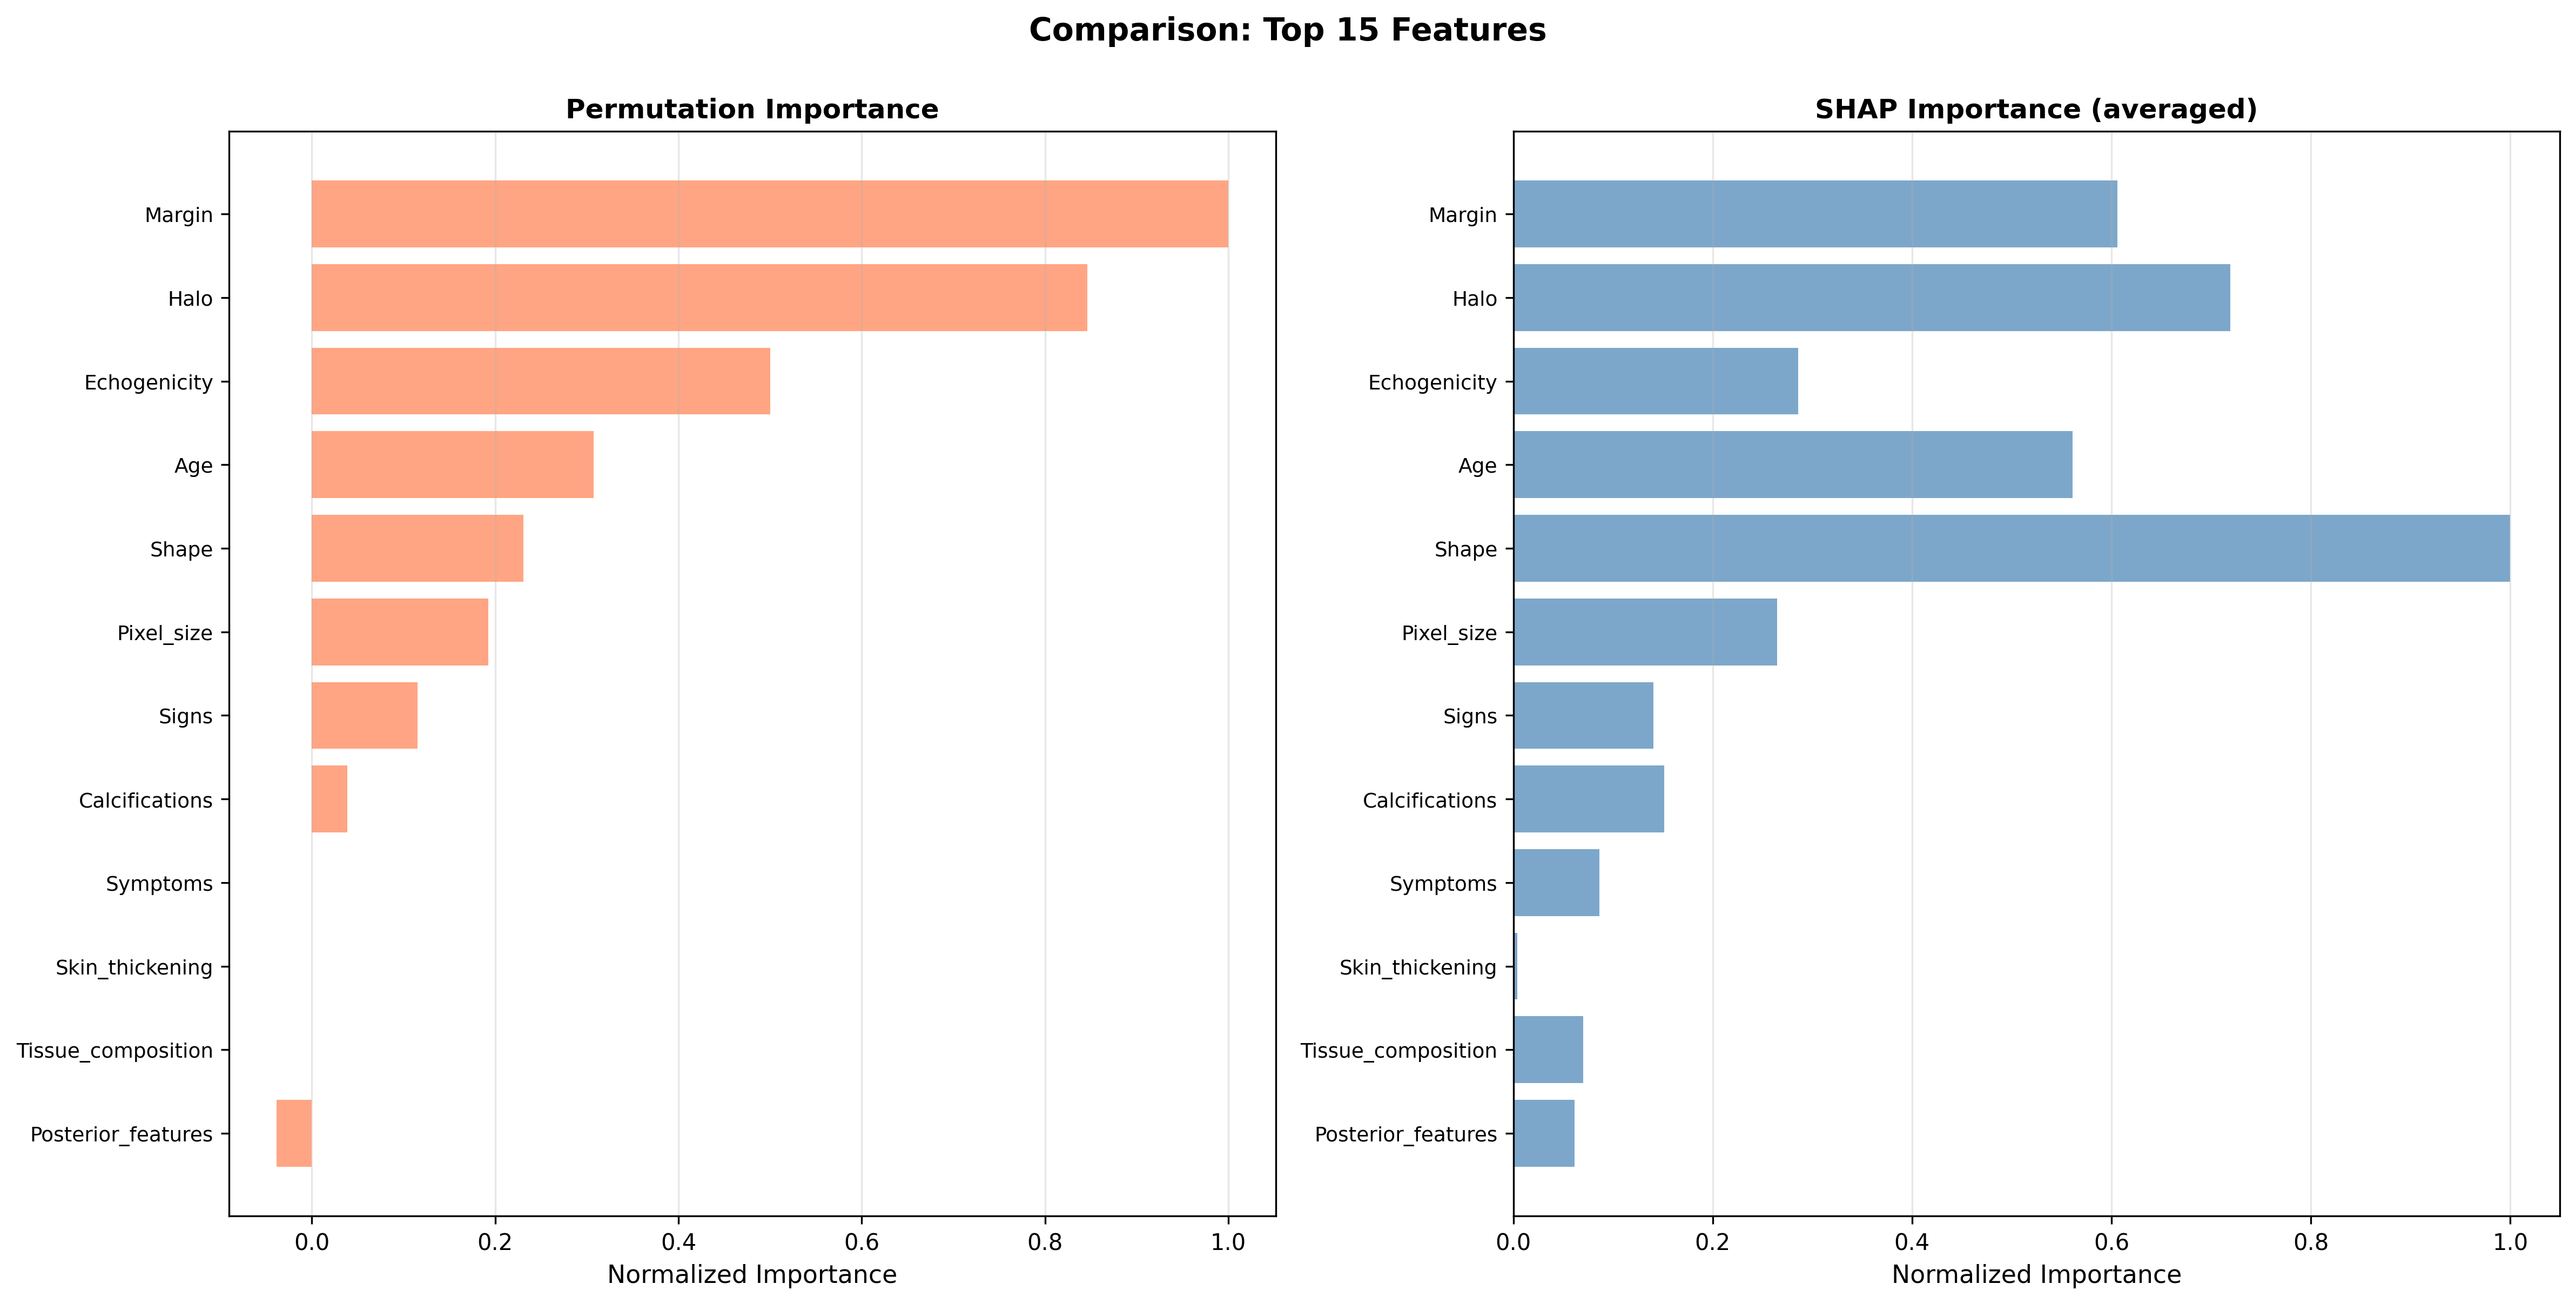

In [ ]:
display(Image(filename="../results/explainability_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_comparison_perm_vs_shap.png"))

In this image we can see that there are some features that are not important for the model prediction with either one of the explanations.
For this reason, I decided to remove them for the second approach. I removed the features: *posterior_feautures*, *tissue_composition*, *skin_thickening* and *Symptoms*

I also had to remove the column *Age*, despite being important according to the explanations. This is because according to the expert opinion of a doctor, if you only have an image, you might not be able to know the age of the patient. For that reason, it was considered to be better to stop using this feature alltogether.

# Second approach - remove unnecesary features

In this second approach I trained the same model but removing the unnecesary features and *Age*. The hyperparameters used were the same with the exception of *drop_columns*. That is:

> epochs: int = 40  
> lr: float = 1e-4  
> batch_size: int = 8  
> dropout: float = 0.2  
> hidden_dims: list = (128, 256)  
> use_encoding: bool = True  
> drop_columns: bool = True  
> custom_weights: bool = False  
> malignant_penalty: float = 1  


The results for this model were as follows:


> **Train Accuracy:**   88.73%  
> **Val Accuracy:**  80.77%  
> **Test Accuracy:**  88.46%  

I also ploted the explanations for this model using SHAP and permutation importance and the results are the following:

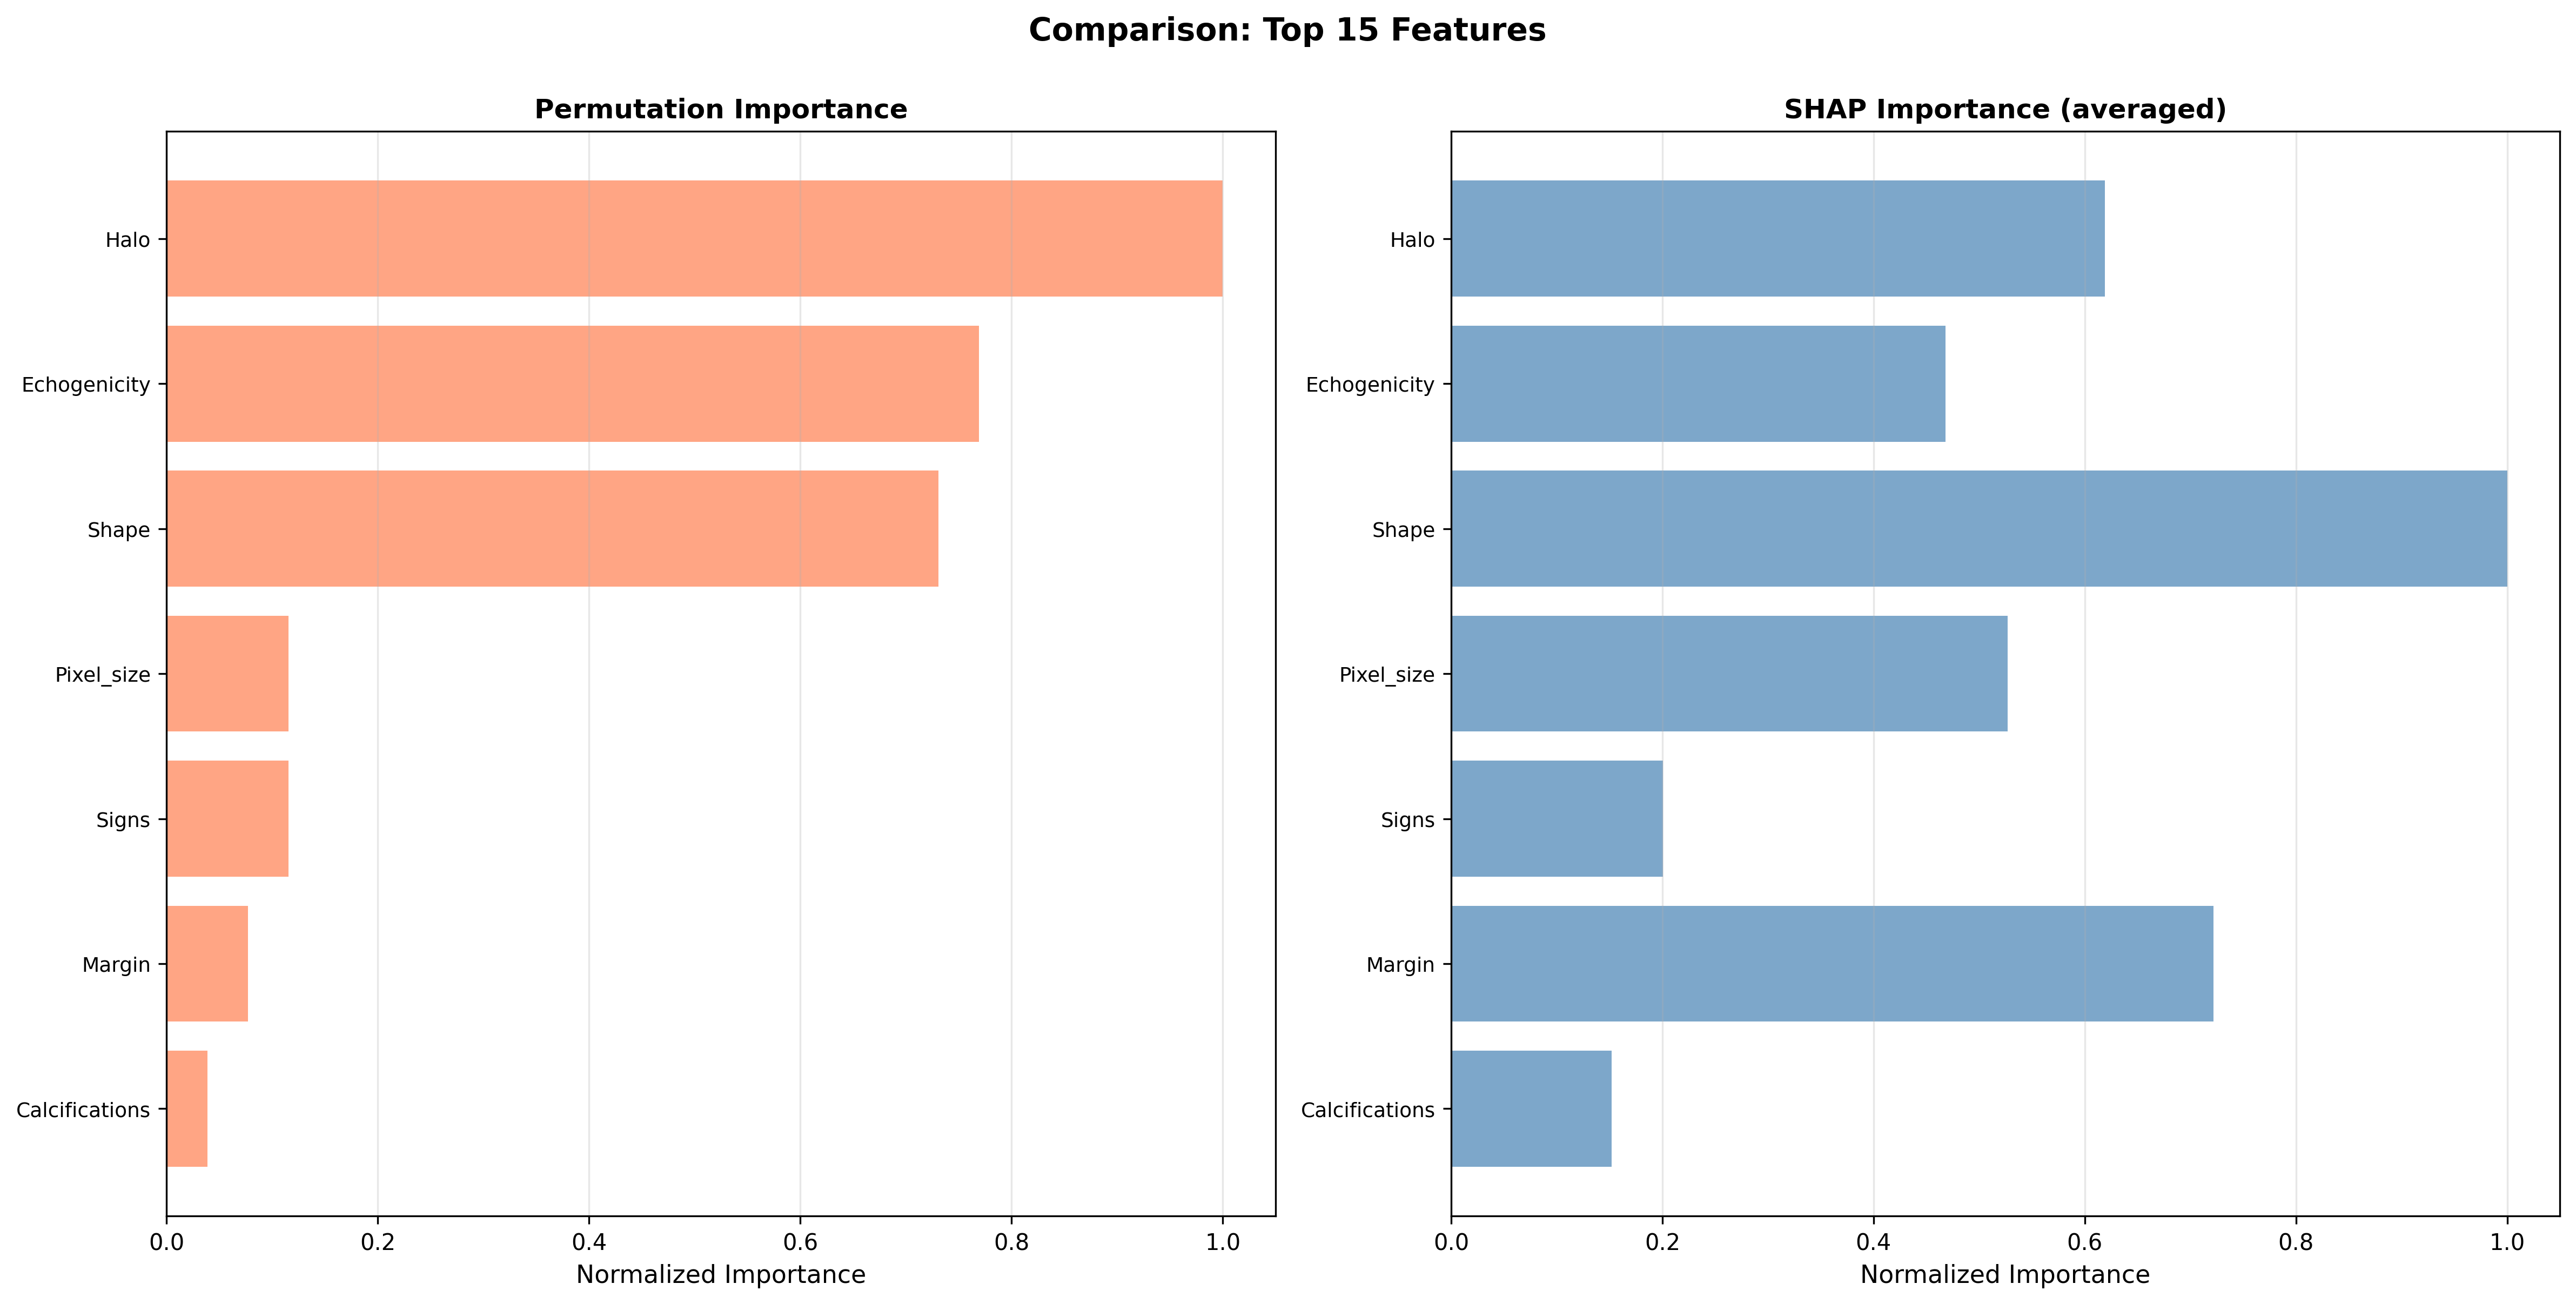

In this plot, it appears that all the remaining features are important for one method or the other, so I decided to keep them. With this improvement. I was able to mantain the model accuracy with less features.

However, there was still something left. That is, when classifying tumors it is more important to detect all malignant tumors on time than to say to someone that they have a malignant tumor that is actually bening (False positives should be less penalized that False Negatives). False Positives will be confirmed with additional tests, but if the test says "bening" there may not be additional tests to confirm it, and the person with the actually malignant tumor will suffer the consequences, that could be fatal.

This lead me to the third approach, that tries to reduce the rate of False Negatives. 

The second approach generates the following confusion matrix:

<!-- <img src="../images_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_confusion_matrix.png" width="700"> -->


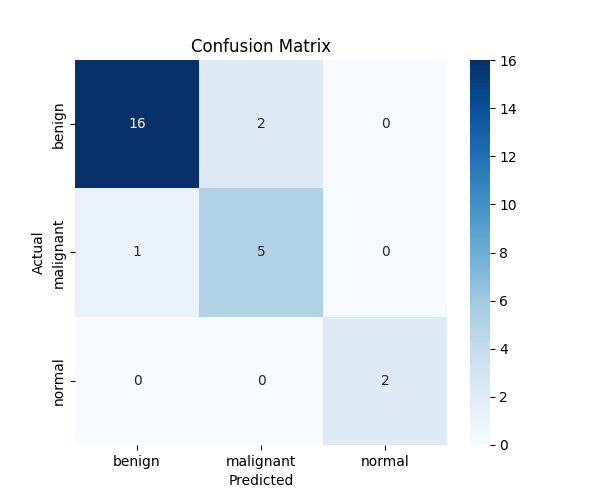

In [ ]:
display(Image(filename="../images_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_confusion_matrix.png"))

# Third approach - avoid false benings

As stated before, in this approach I tried to reduce the rate of False negatives. For that, I added weights to the loss that penalize malignant tumors being classified as bening.

To replicate the results, the train_tabular.py should have the following configuration:

> epochs: int = 40  
> lr: float = 1e-4  
> batch_size: int = 8  
> dropout: float = 0.2  
> hidden_dims: list = (128, 256)  
> use_encoding: bool = True  
> drop_columns: bool = True  
> custom_weights: bool = True  
> malignant_penalty: float = 1.5  

I tried different penalty coefficients and the results with the better compromise between accuracy and False Negative reduction is 1.5.

With this hyperparameters the results are:
> **Train Accuracy:**   86.76%  
> **Val Accuracy:**  80.77%  
> **Test Accuracy:**  88.46%  

And the confusion matrix results are:

<!-- <img src="../images_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_confusion_matrix.png" width="700"> -->

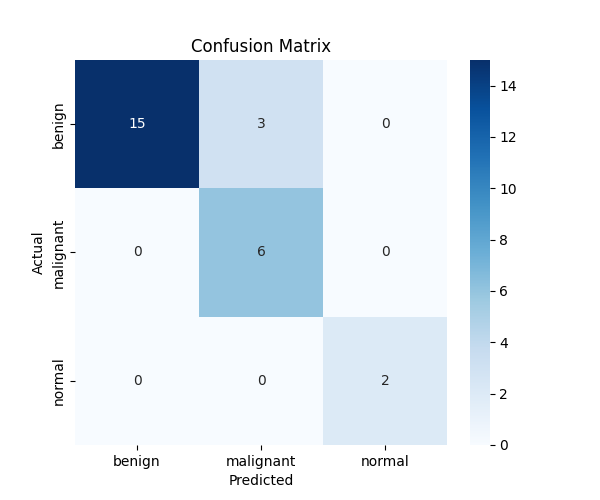

In [ ]:
display(Image(filename="../images_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_confusion_matrix.png"))

This shows that the accuracy is the same, but now the model does not classify anything as malignant when it is not sure.

I also ploted the same explanations as before with SHAP and permutation importance:

<!-- <img src="../results/explainability_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_comparison_perm_vs_shap.png" width="700"> -->

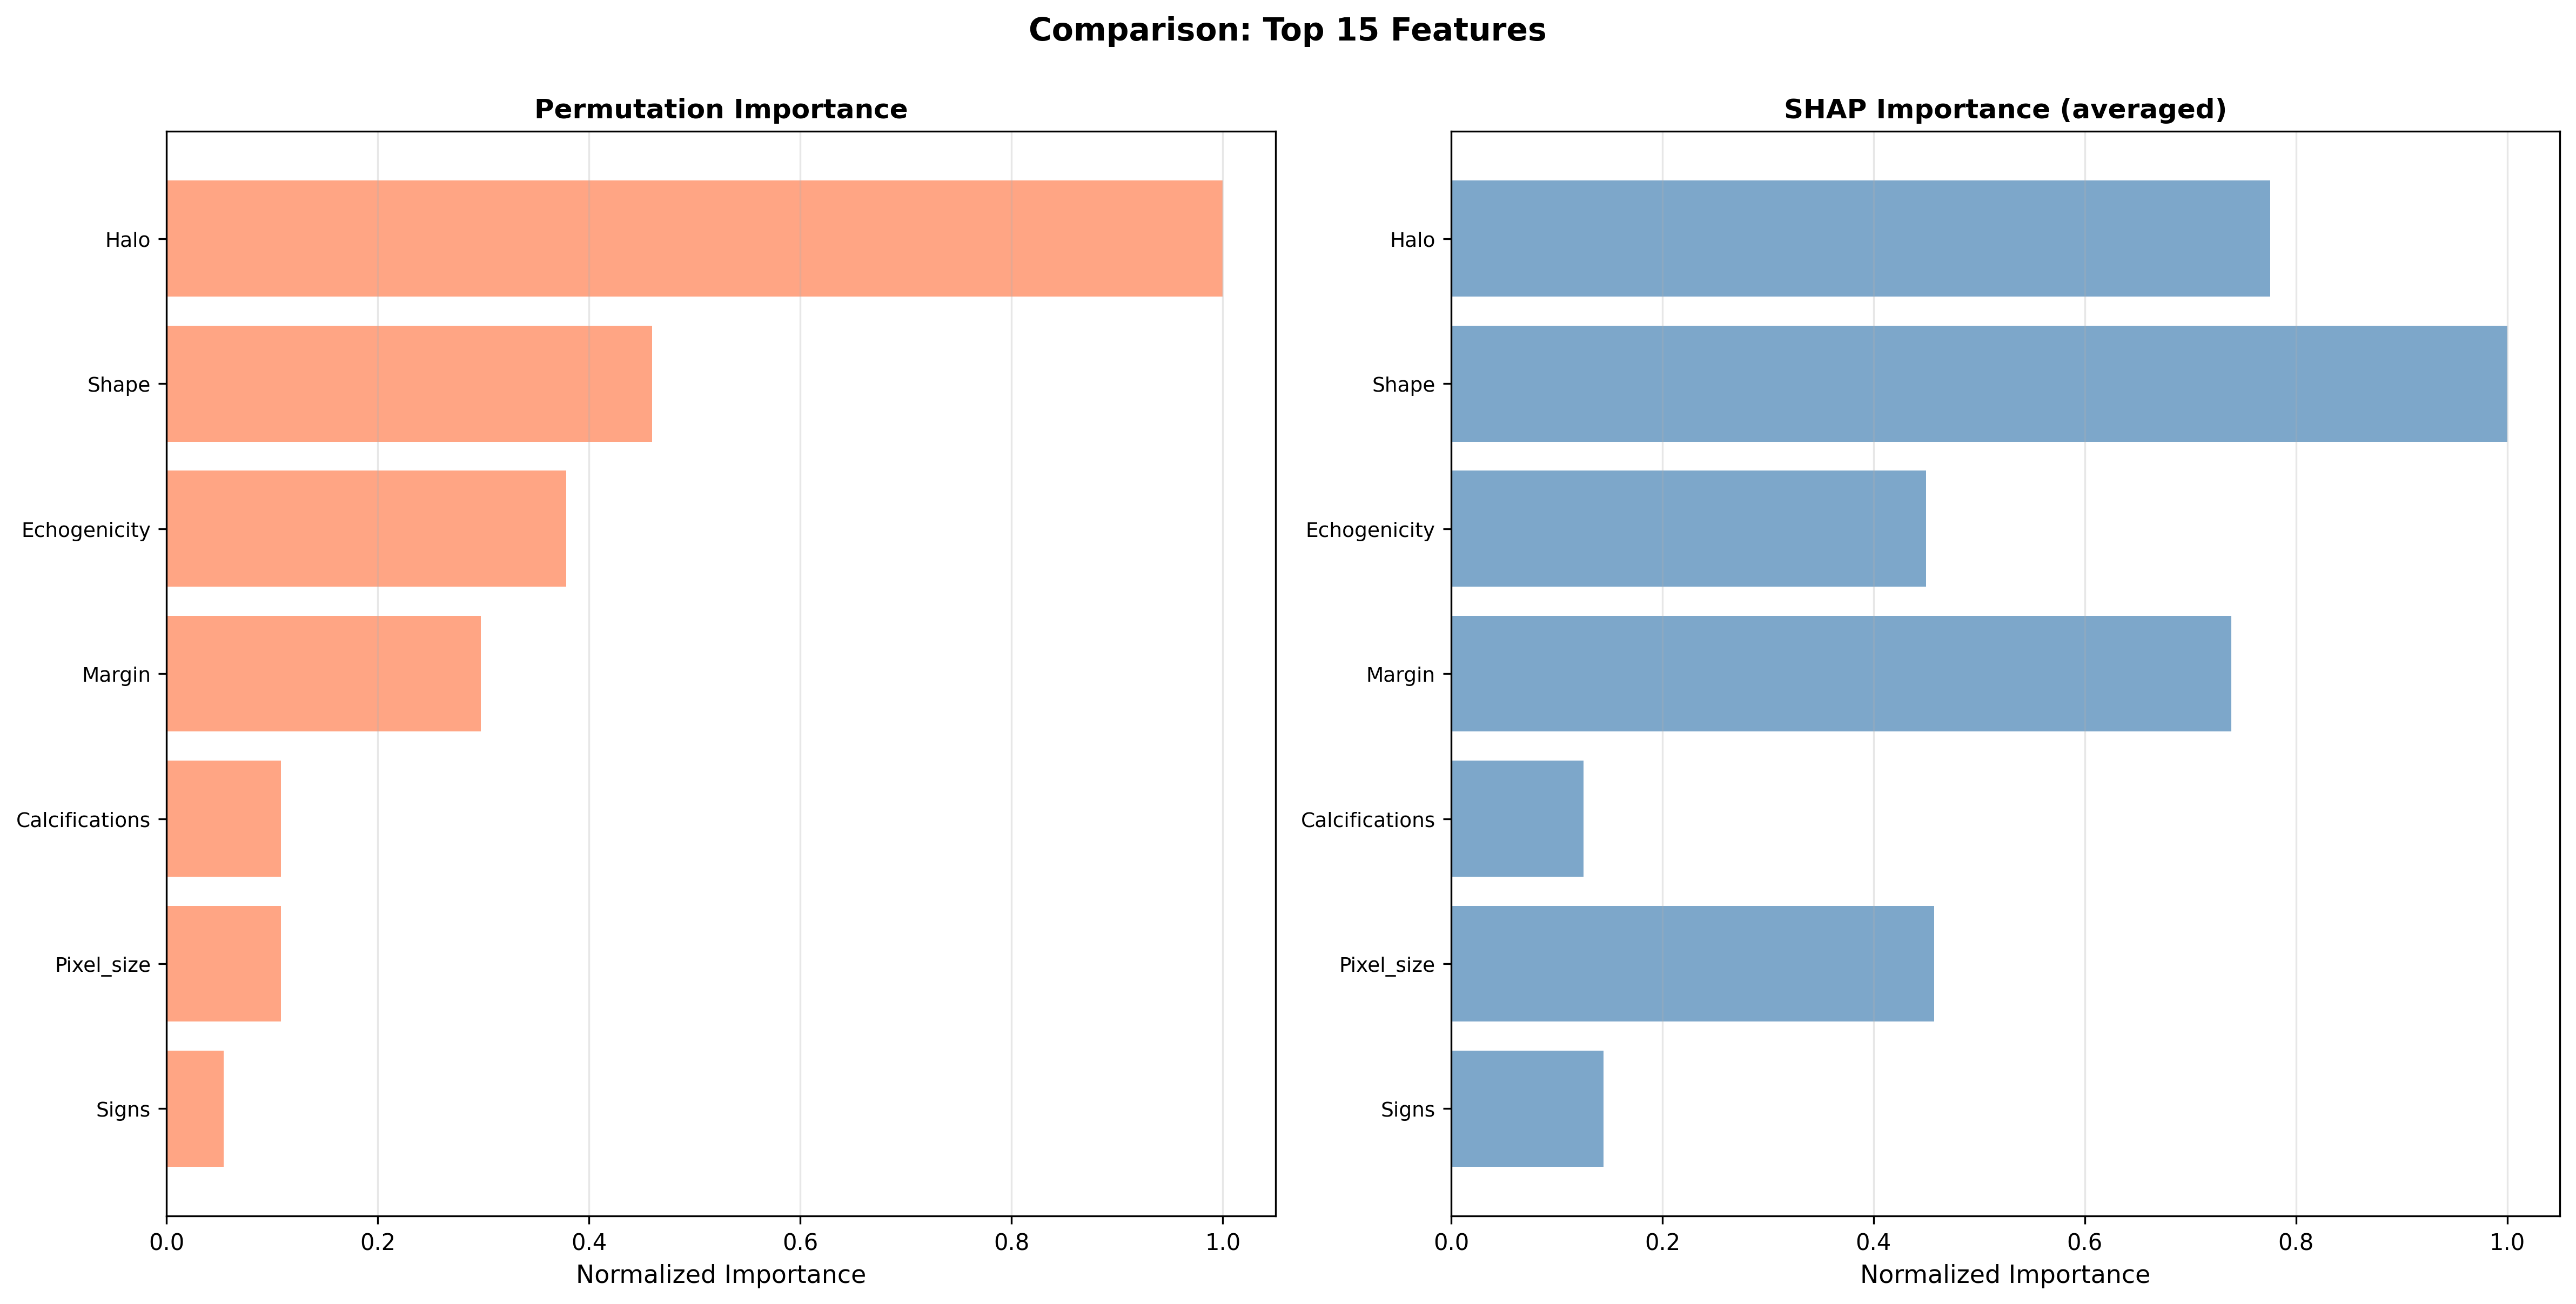

In [ ]:
display(Image(filename="../results/explainability_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_comparison_perm_vs_shap.png"))

The explanations vary a little bit, but all the features remain important according to this explanations. For each individual class the results are:

<!-- <img src="../results/explainability_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_shap_summary_benign.png" width="700"> -->

<!-- <img src="../results/explainability_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_shap_summary_malignant.png" width="700"> -->

<!-- <img src="../results/explainability_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_shap_summary_normal.png" width="700"> -->

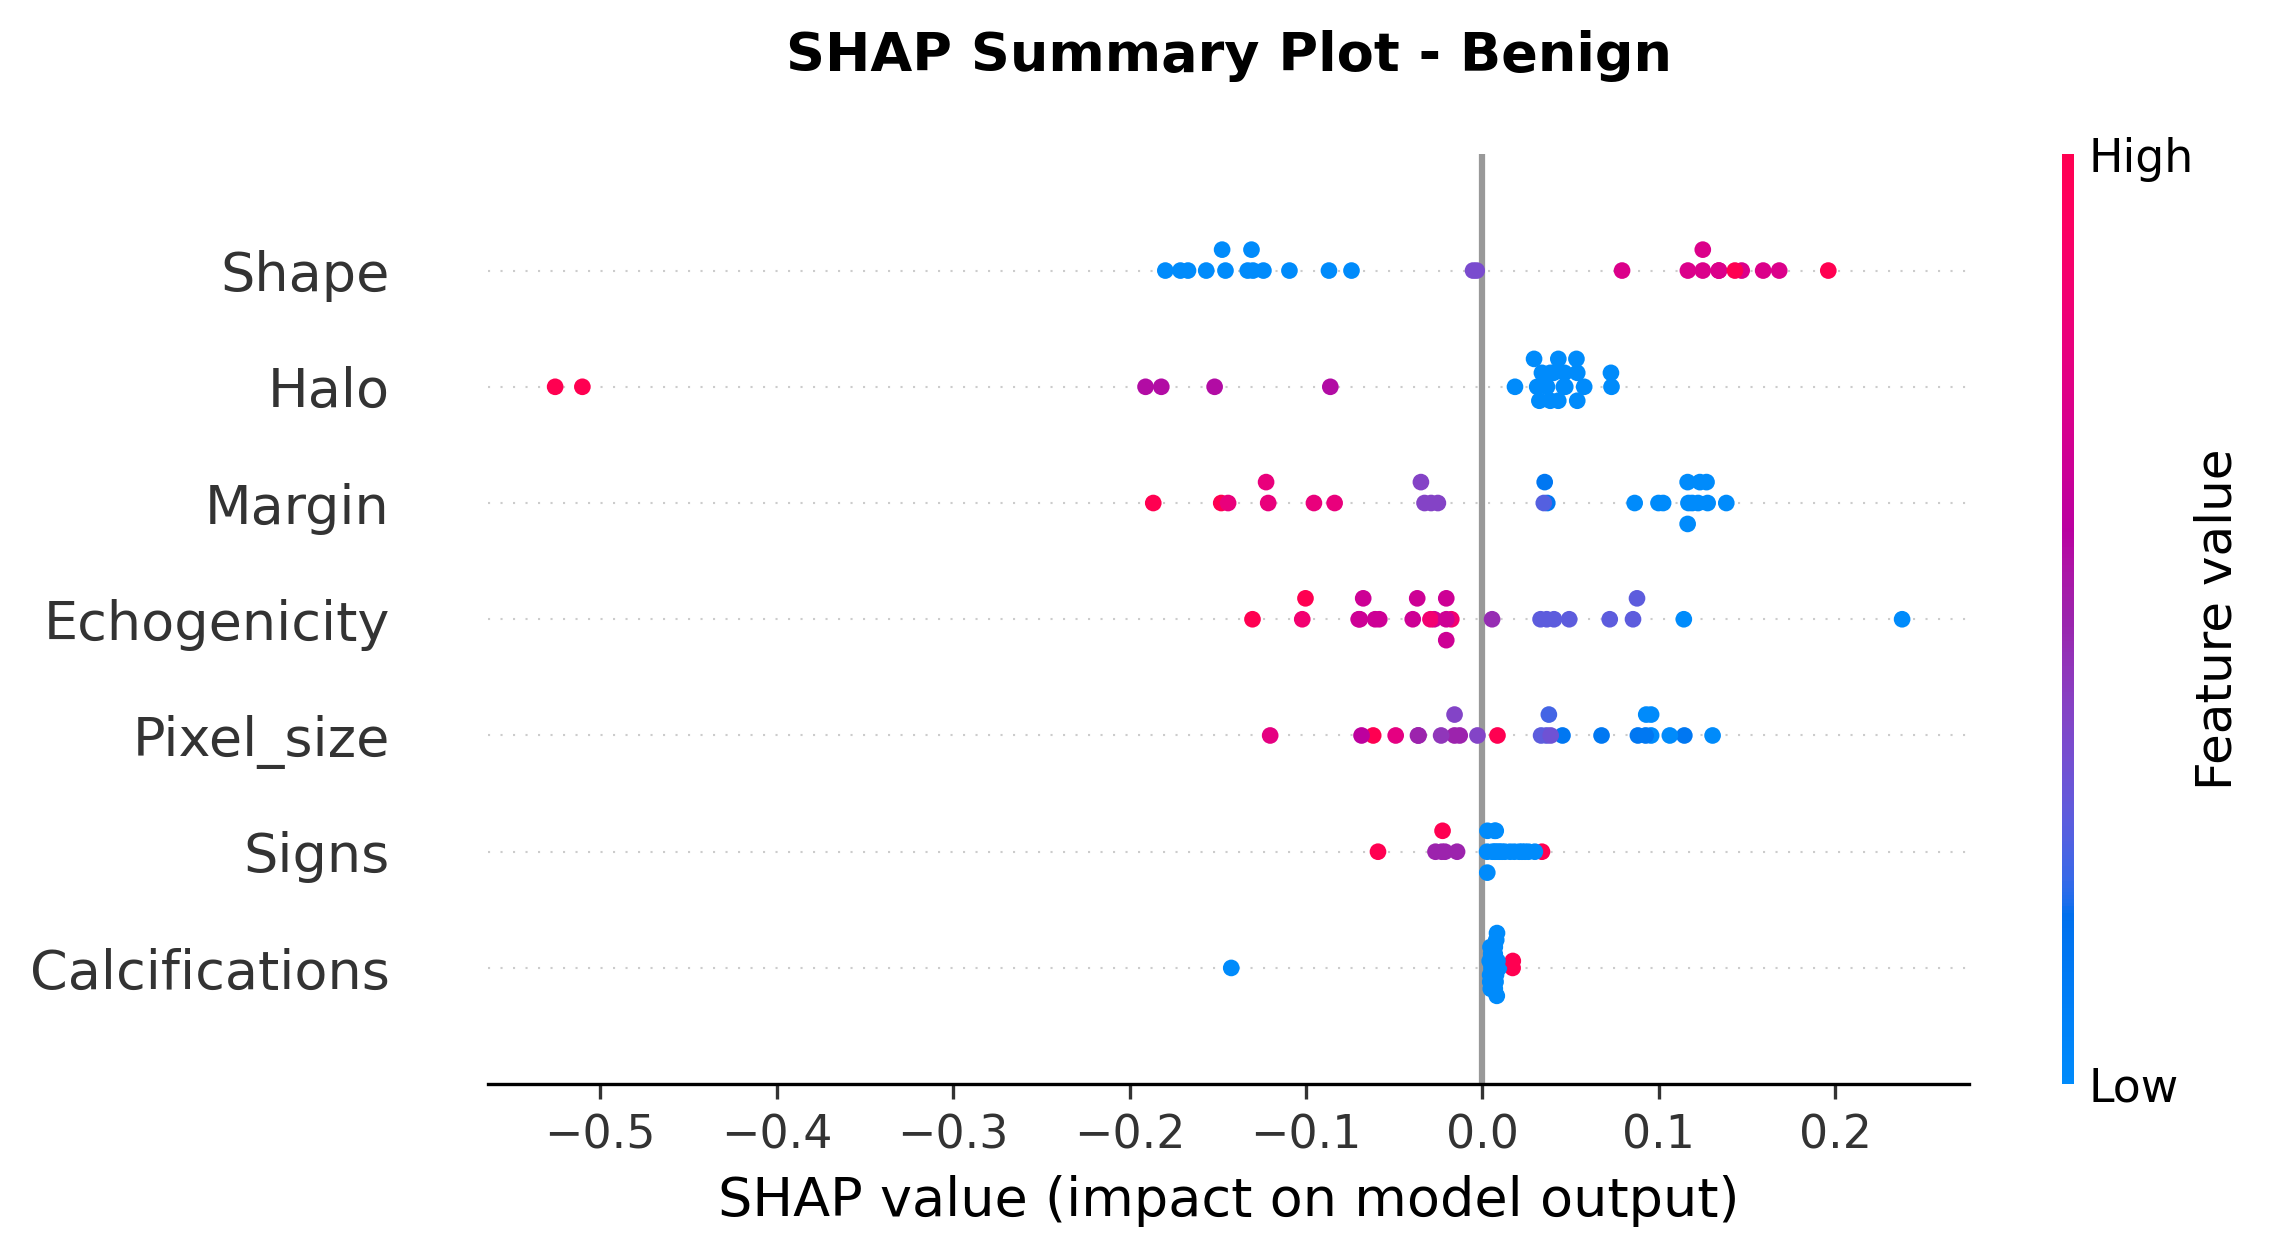

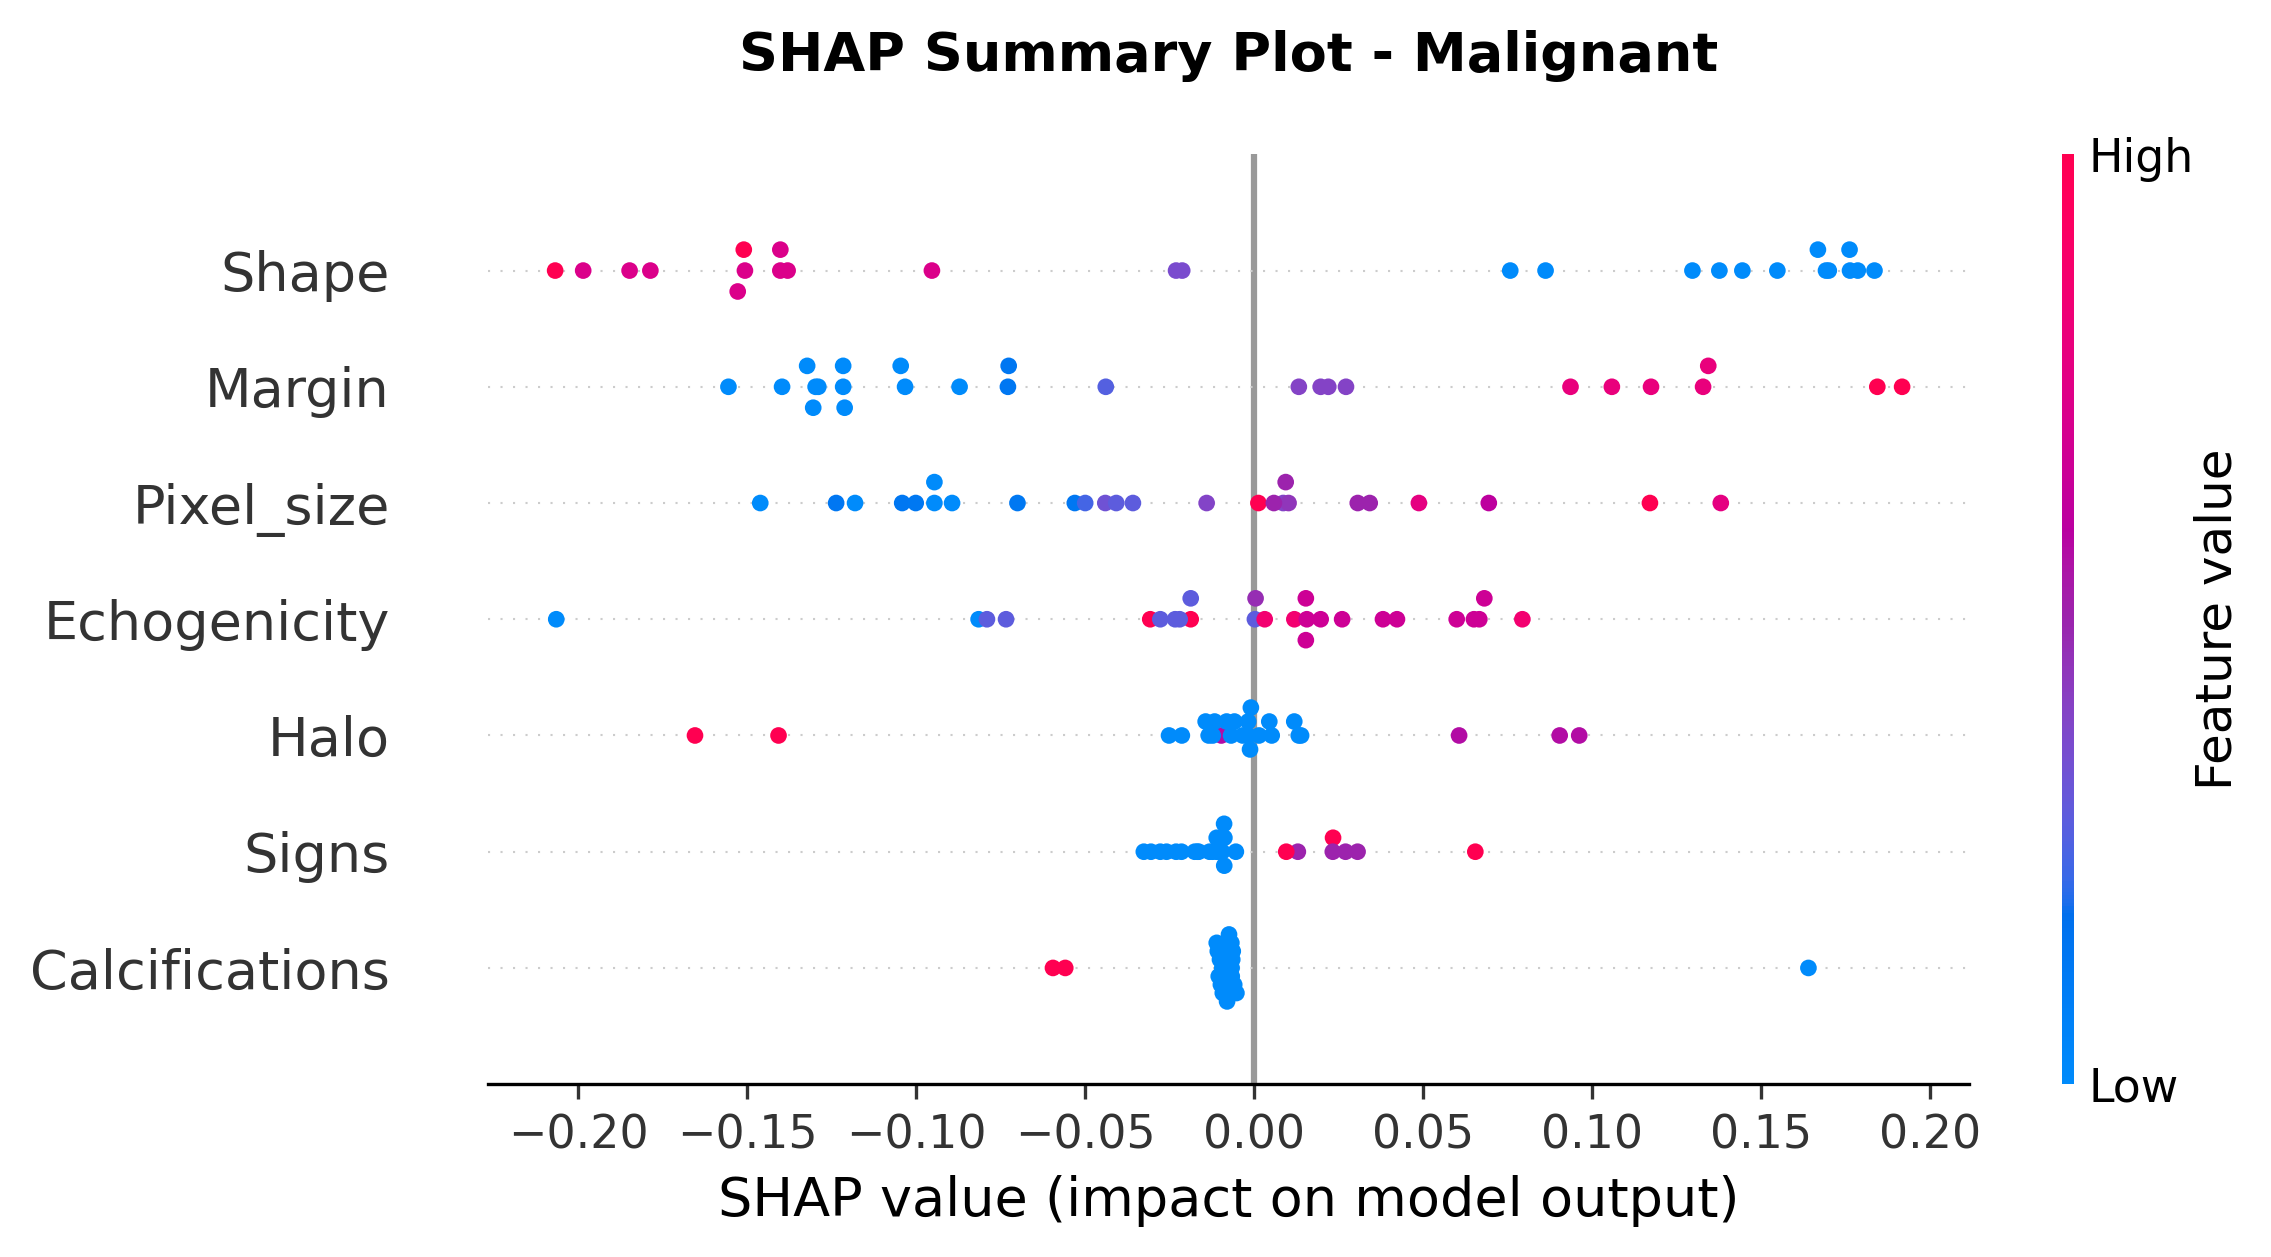

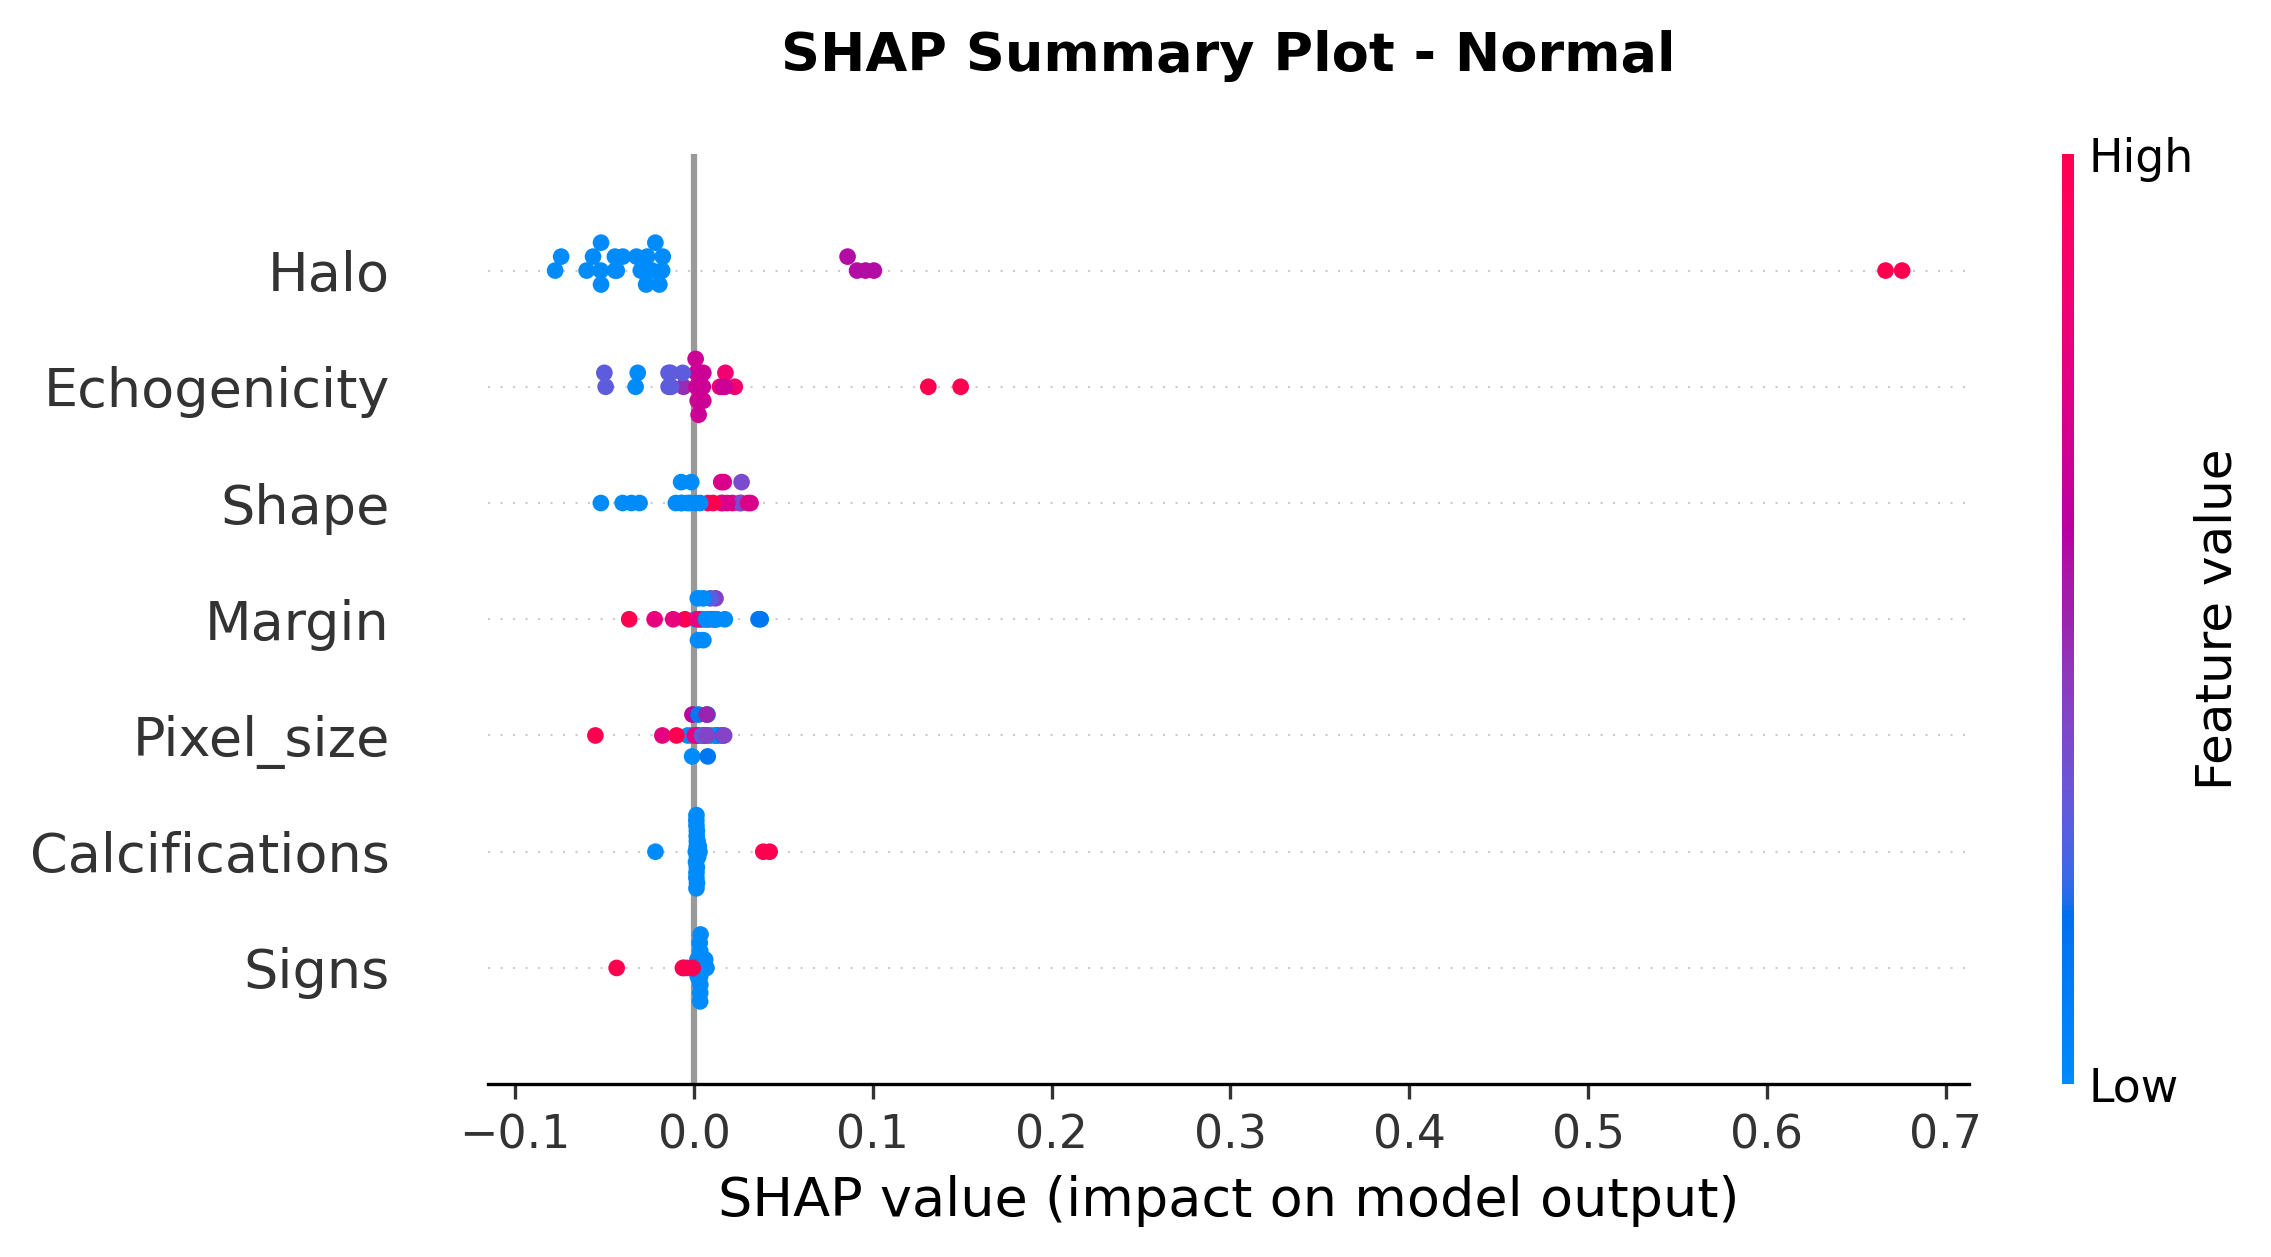

In [ ]:
display(Image(filename="../results/explainability_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_shap_summary_benign.png"))
display(Image(filename="../results/explainability_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_shap_summary_malignant.png"))
display(Image(filename="../results/explainability_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_shap_summary_normal.png"))

This explanations for class show something interesting. For example, the Shape appears to be a good classifier between malignant and bening, positive values incline the model towards bening and negative towards malignant. With the margin something similar happens

I chose SHAP and permutation importance to evaluate feature importance and provide a global view of the model, as both are model-agnostic methods that offer robust results. SHAP values measure the contribution of each feature relative to a baseline, whereas permutation importance does not rely on a baseline. By using both methods, I compared their outputs to ensure that the feature importance ranking is consistent. The similar results suggest that the explanation is robust.

# Explain samples

Now, I am going to explain different samples of the dataset. I'm going to use a sample for each class. For the explanations, I wanted to see the impact of different features in the output, so I used SHAP using as baseline 100 of the images of the dataset. I also plotted the probabilities assigned to each class, to assess the differences. 

### Malignant

The explanations for a malignant sample given by SHAP is:


<!-- <img src="../results/explainability_s_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_sample_3_feature_values.png" width="700"> -->


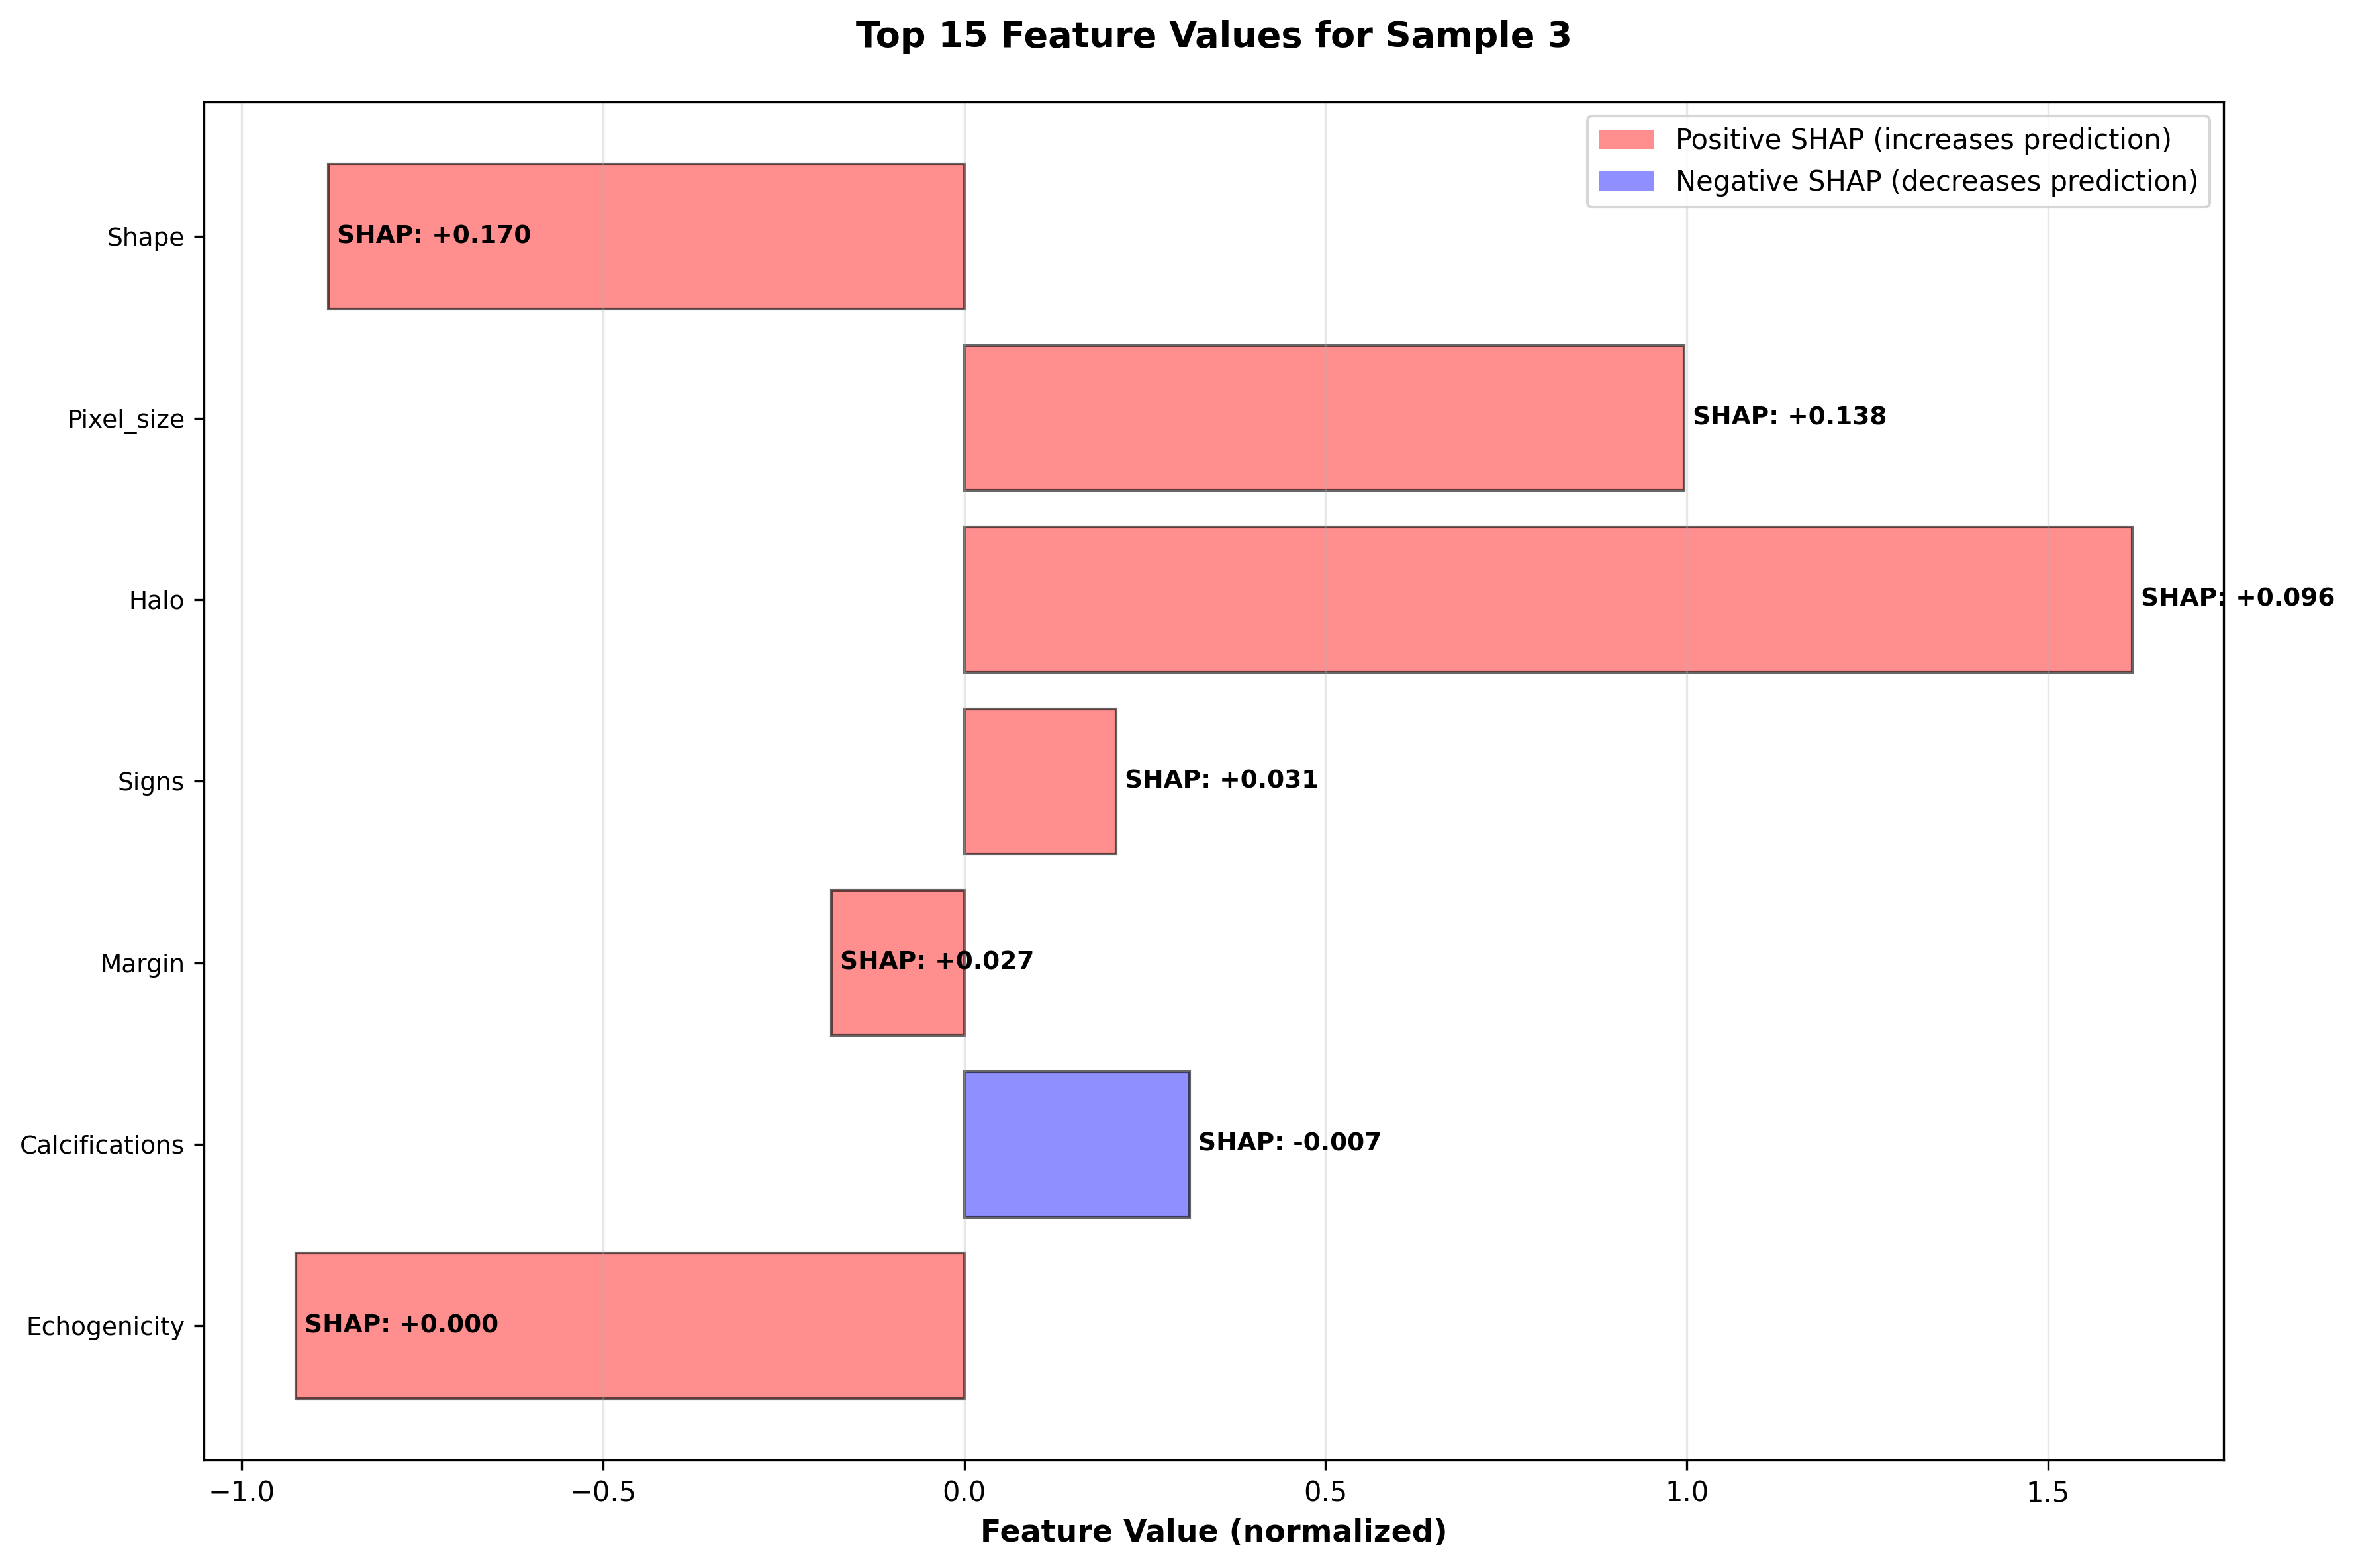

In [ ]:
display(Image(filename="../results/explainability_s_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_sample_3_feature_values.png" ))

These results match the global explanations. For example, the Shape towards -1, leads the model toward malignant, as well as Halo. There are others that do not match global explanations, such as margin. This could be explained by the fact that SHAP values are local explanations so certain features may strongly influence individual predictions even if they are less important on average across the dataset or may only have a strong influence in certain cases.

### Beningn

The explanations for a benign sample given by SHAP is:

<!-- <img src="../results/explainability_s_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_sample_1_feature_values.png" width="700"> -->

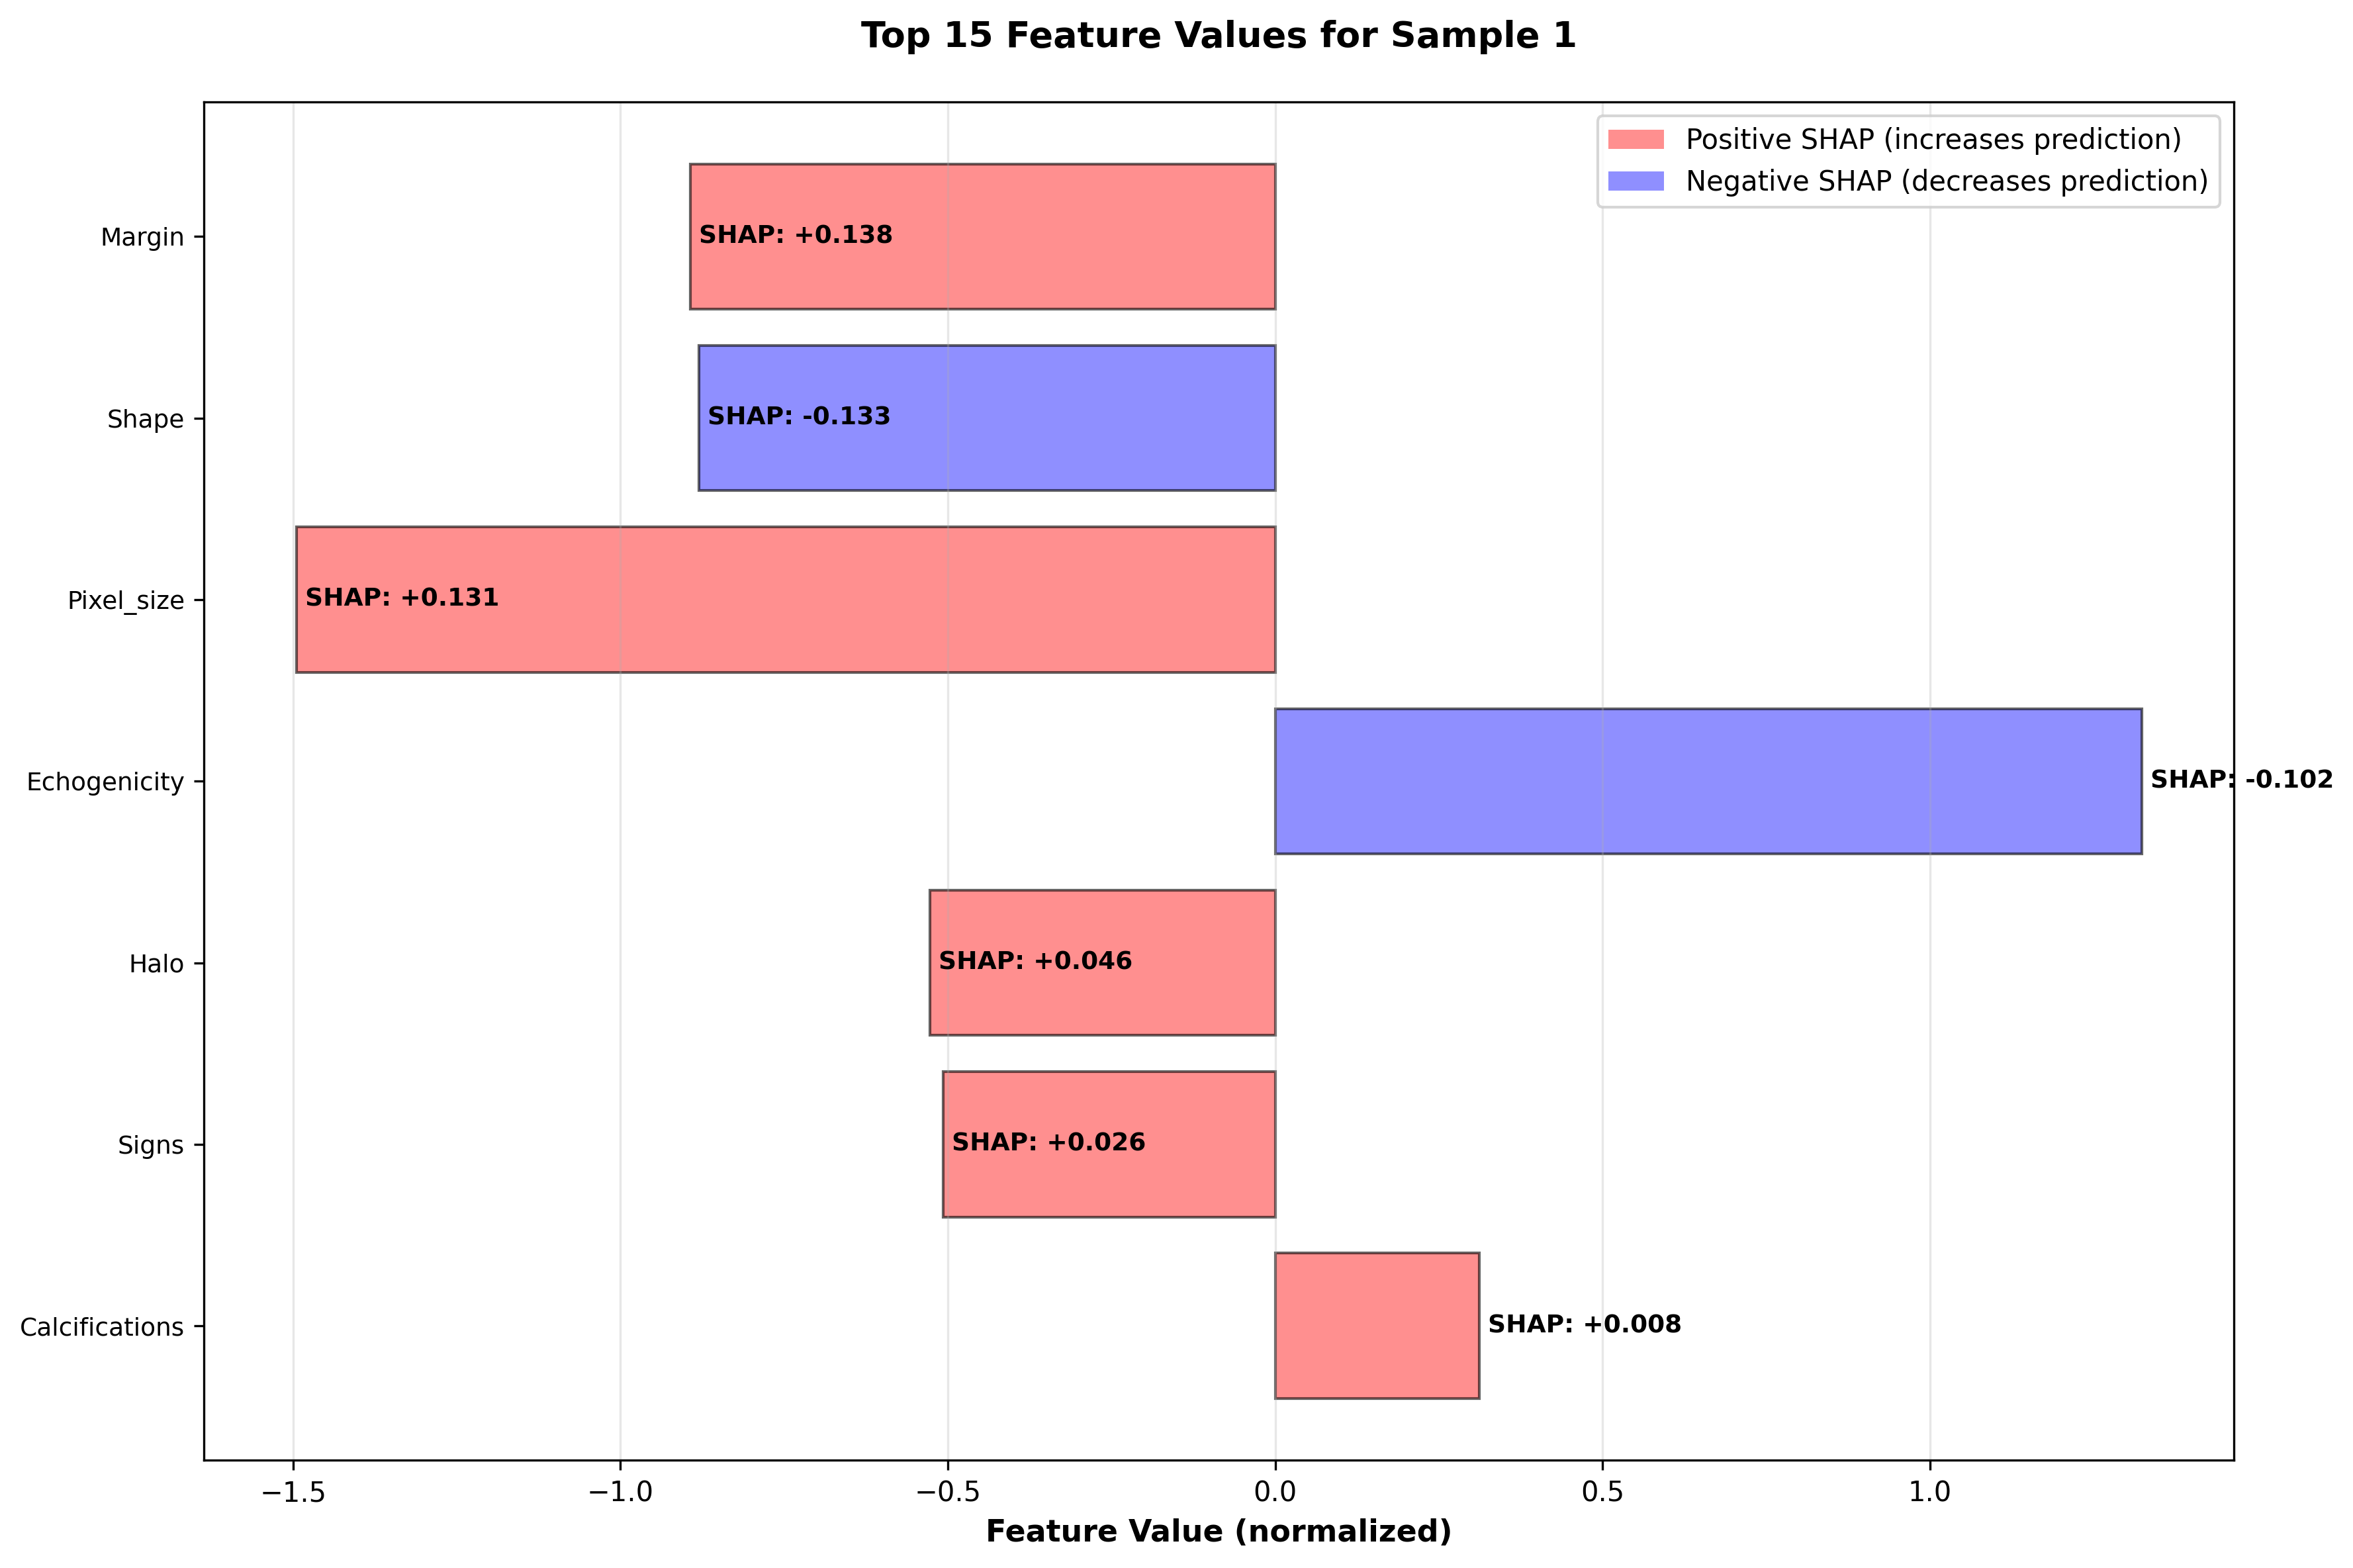

In [ ]:
display(Image(filename="../results/explainability_s_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_sample_1_feature_values.png"))

As before, some values, like the shape or echogenicity (a low value decreases the prediction) correspond to the global explanation, but others (signs) do not. I have attributed this to the same effect than before.

### Normal

The explanations for a normal sample given by SHAP is:

<!-- <img src="../results/explainability_s_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_sample_0_feature_values.png" width="700"> -->

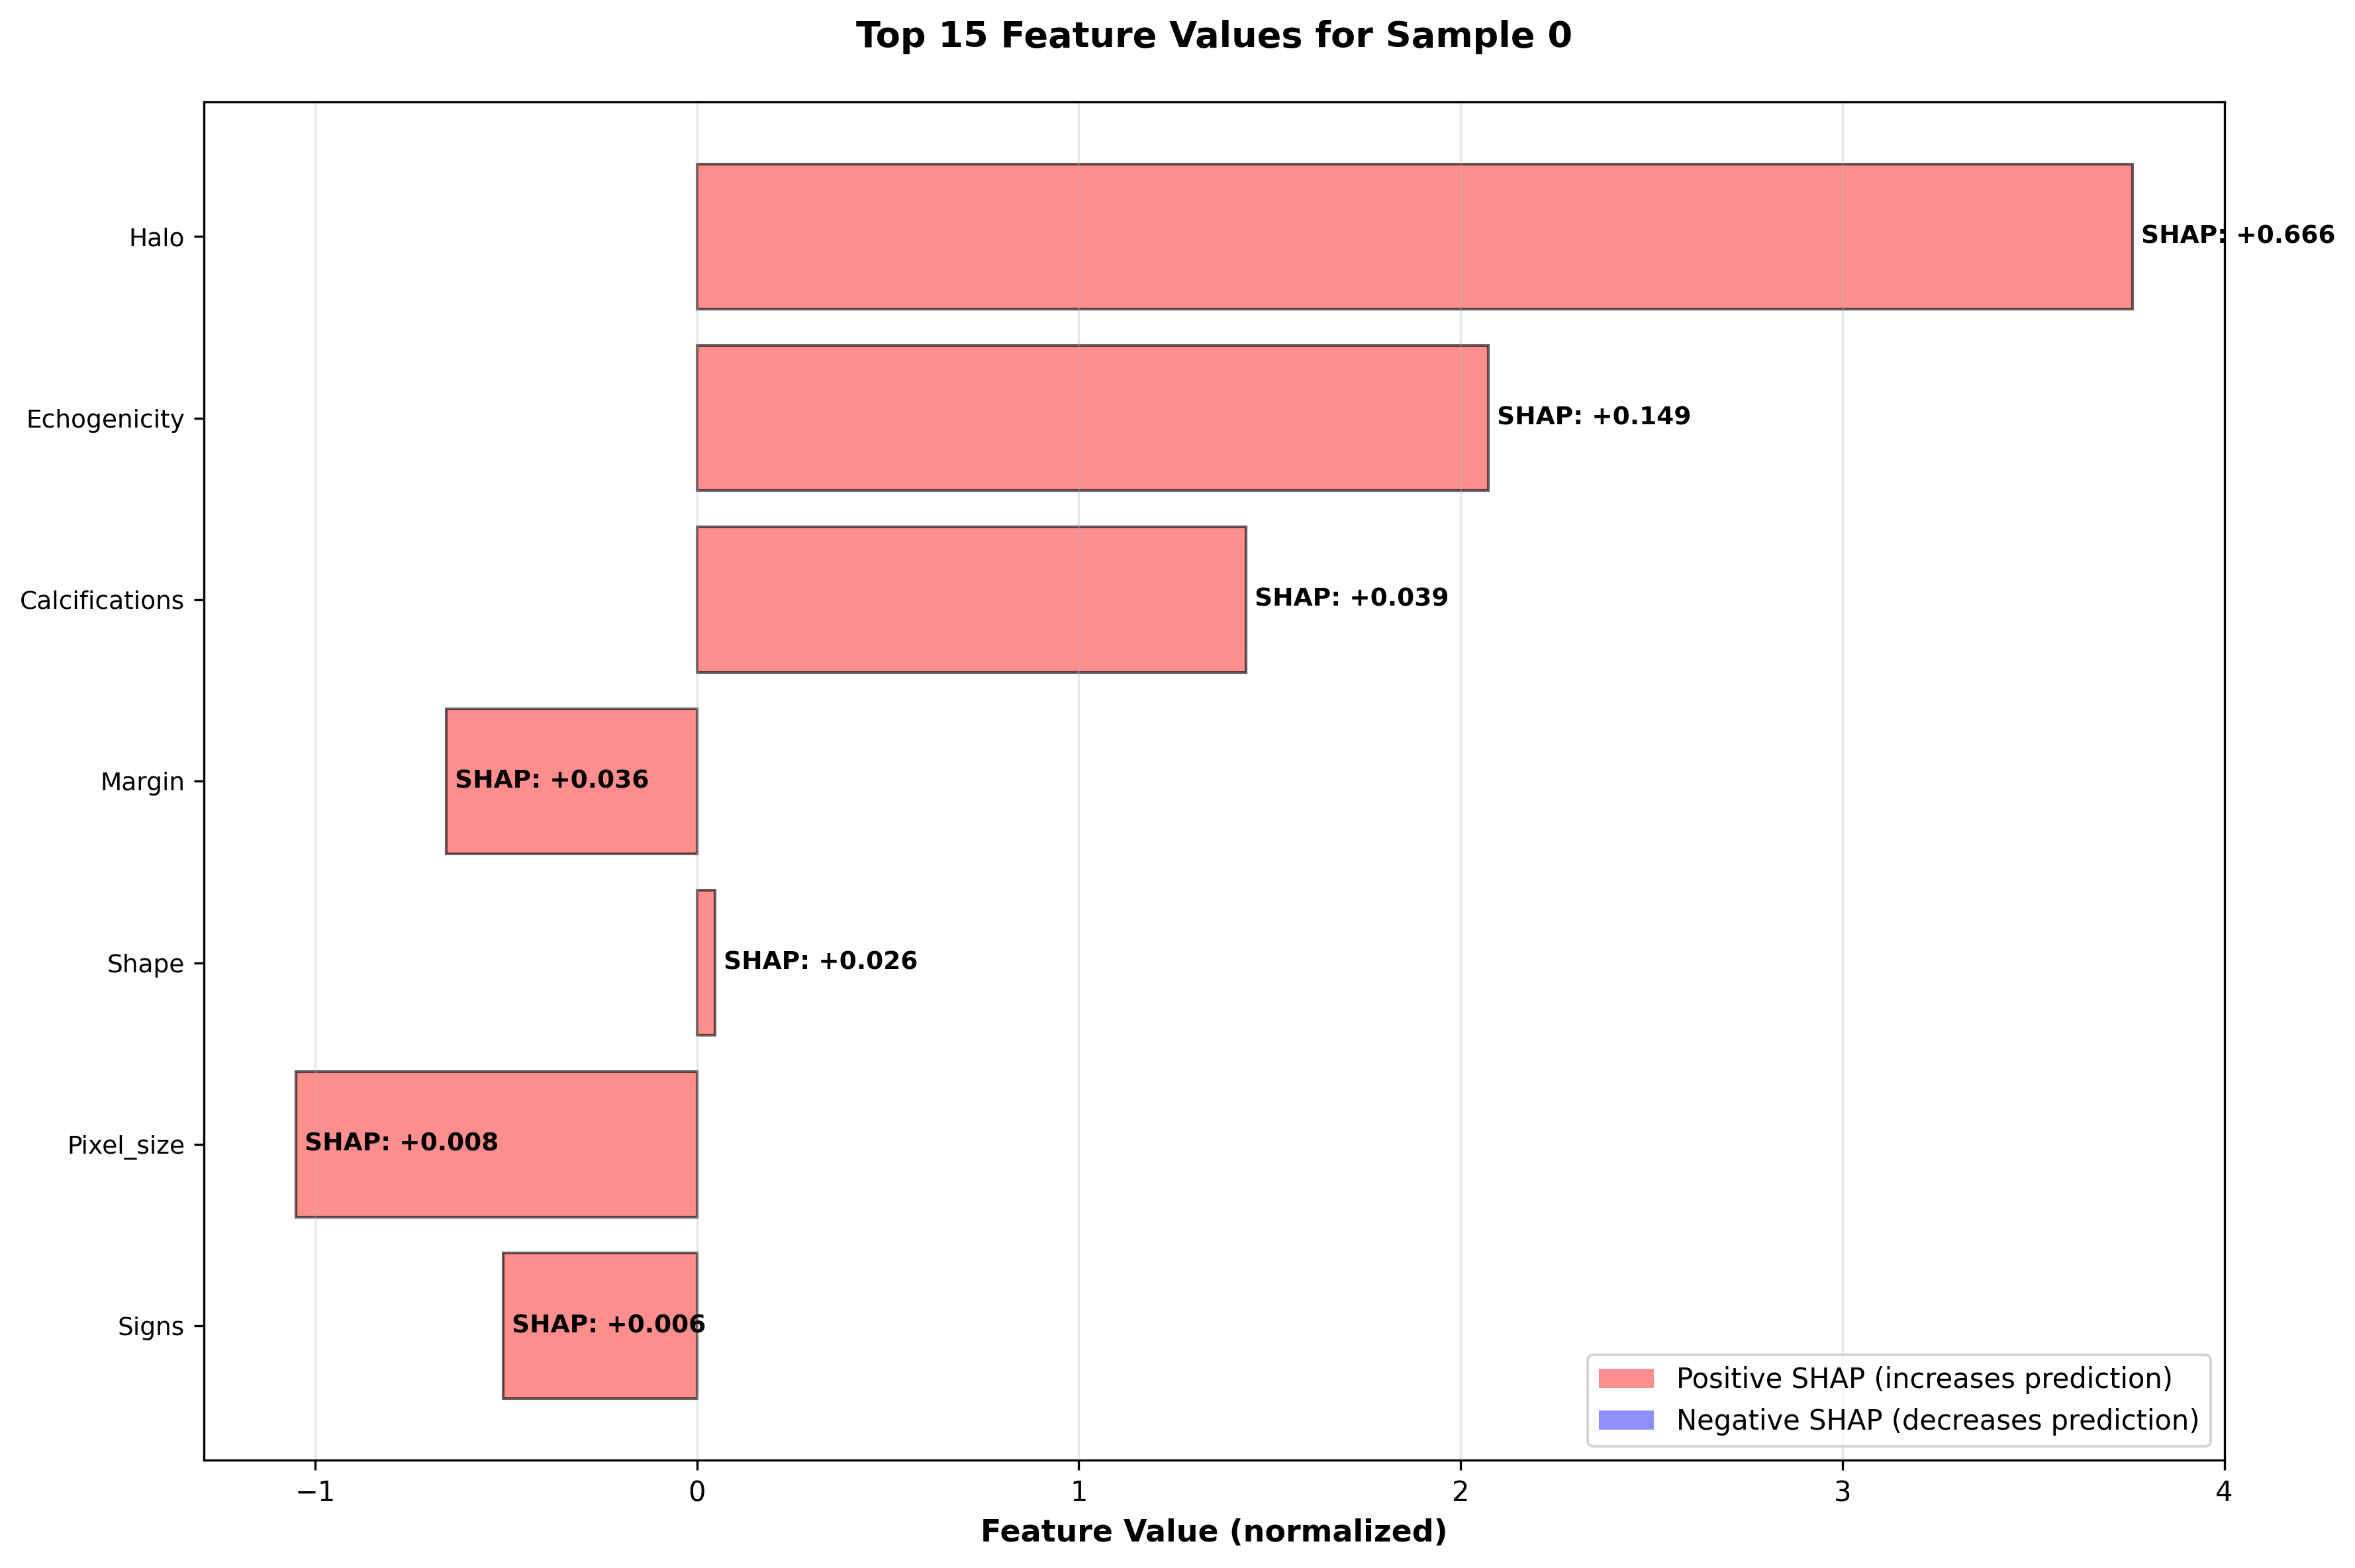

In [ ]:
display(Image(filename="../results/explainability_s_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_sample_0_feature_values.png"))

The explanations for this graph is very similar to the ones above.

### Comparison

I tried to compare the 'confidence' de model has in the prediction to see if the coeffient that 'helps' the model to have more FalseMalignants than FalseBenigns, has had an impact in the model output.

<!-- <img src="../results/explainability_s_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_samples_comparison.png" width="700"> -->


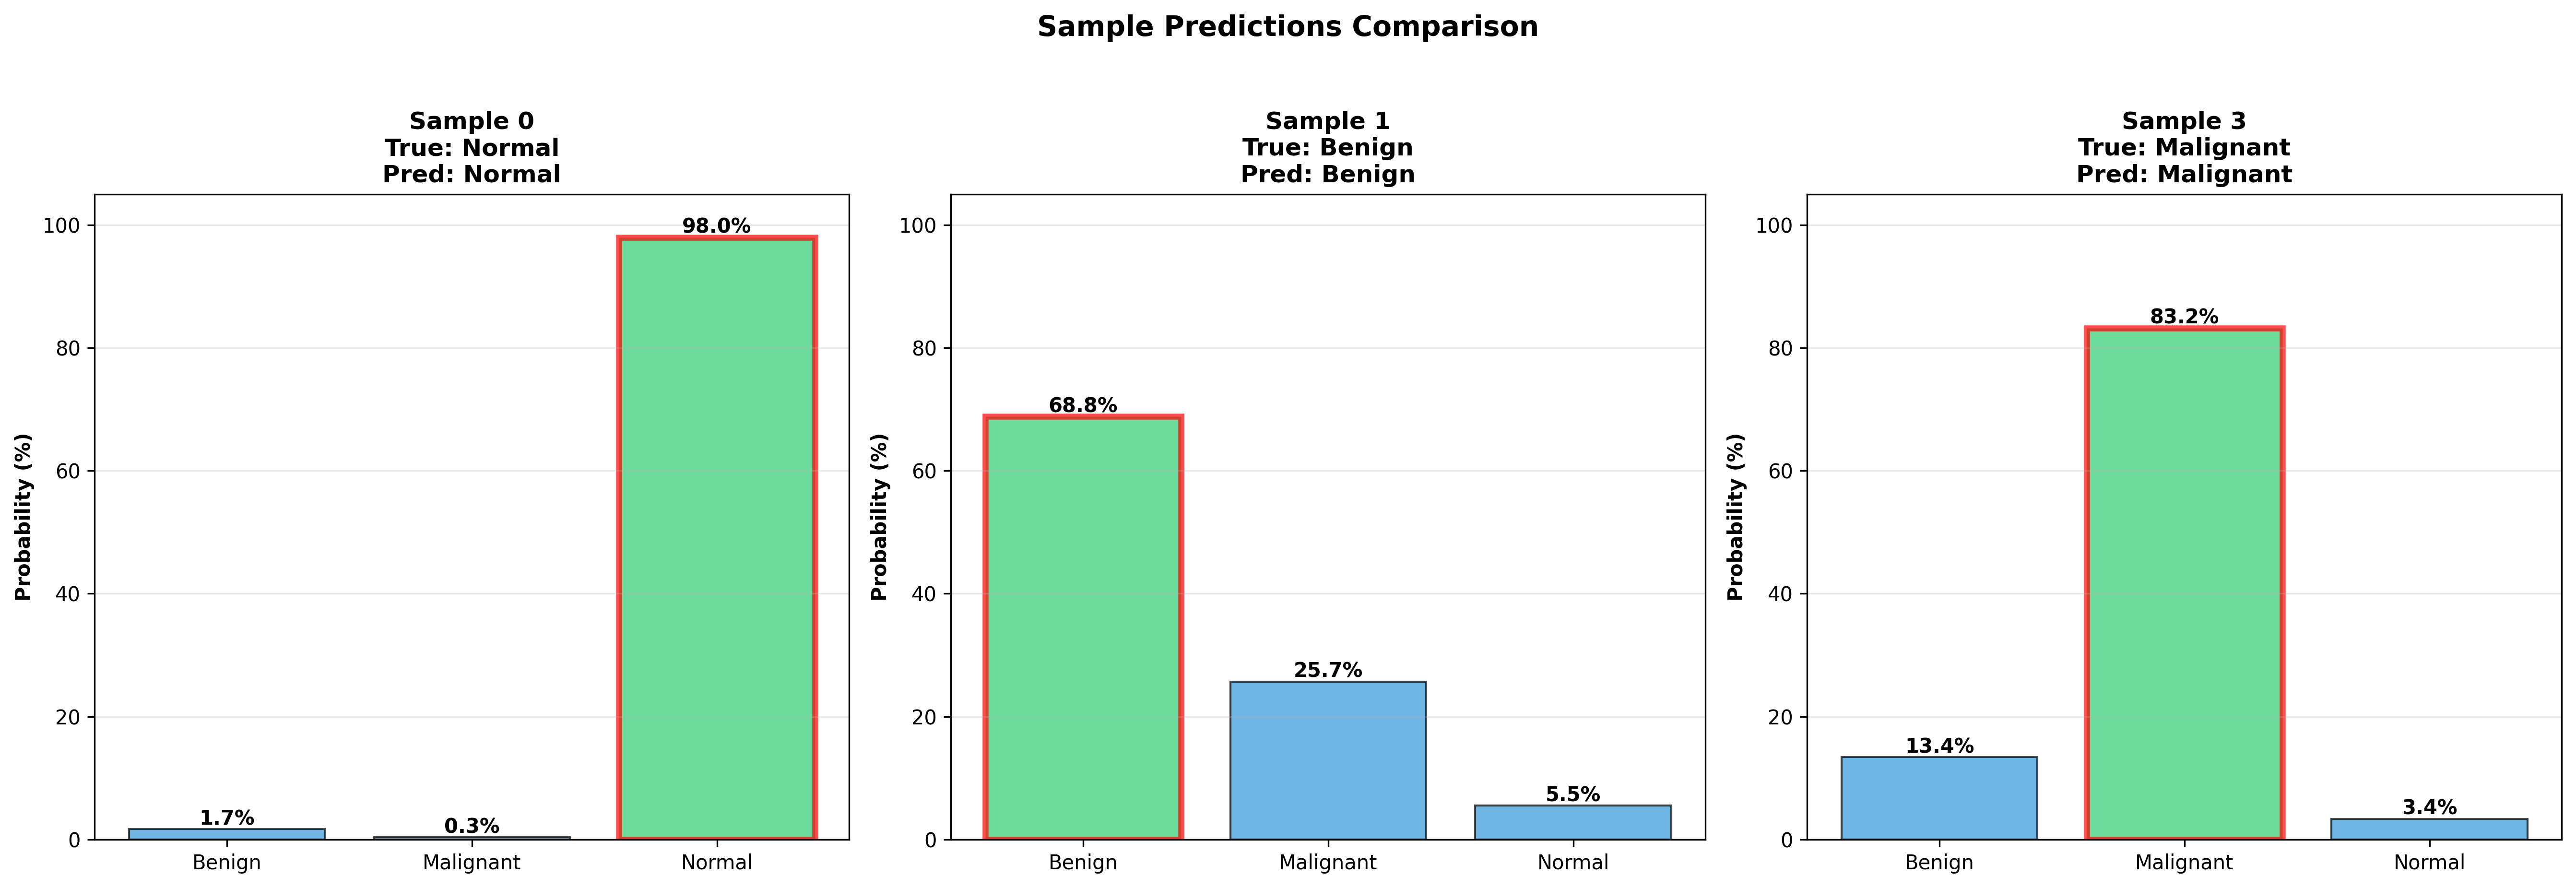

In [ ]:
display(Image(filename="../results/explainability_s_tabular/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_samples_comparison.png"))


The plot above shows how the model is really confident for the normal prediction (which makes sense given that the loss coeffient take into account the number of samples for each class and there are only 4 normal images, so the coeffient is really high). The comparisons between bening and malignant may indicate that the model leads more towards predicting malignant instead of bening (because malignat has a high probability in the bening case). This could make sense as the idea of the loss coeffient was to only classigy a sample as bening if the model is sure to discard the malignant prediction.

# XAI Evaluation

Last, I'm going to evaluate the XAI methods used above. In particular, I wanted to know if the feature importance given by permutation importance and SHAP make sense. In particular, I'm going to remove and add noise (in separate tests) to the most important columns according to SHAP and see if the predictions decrease. I'm also going to delete random features to see if there is any difference.

First, by removing the most important features in order we get the following graph:

<!-- <img src="../results/xai_evaluation/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_monotonicity_test.png" width="700"> -->

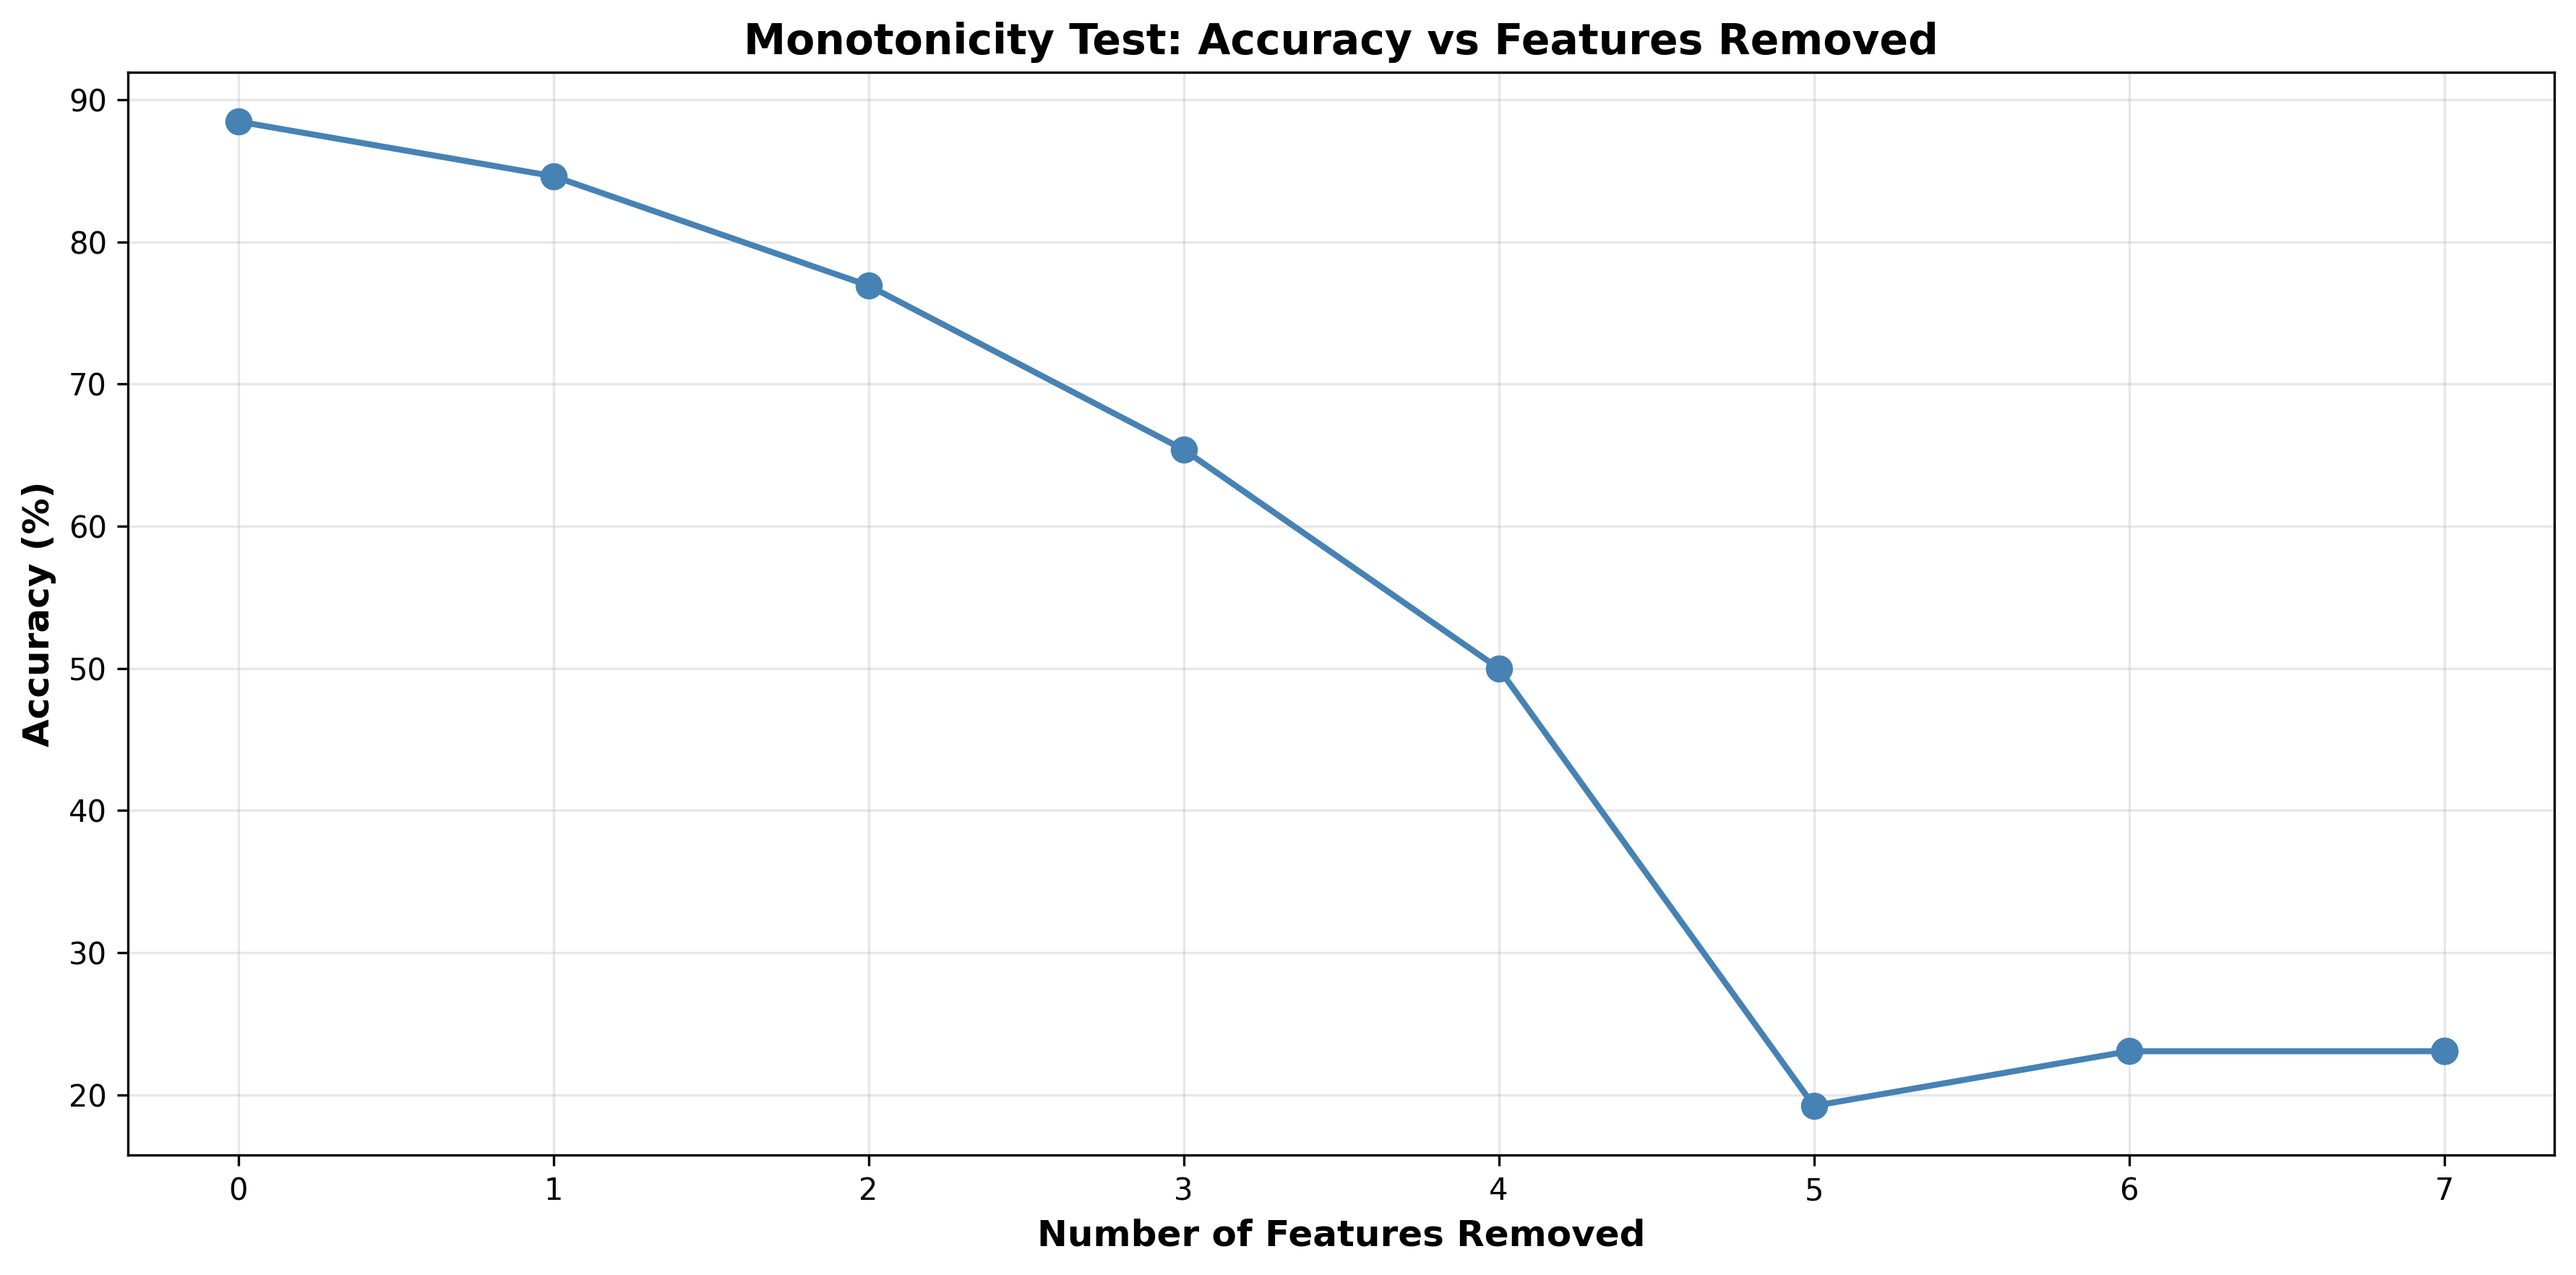

In [ ]:
display(Image(filename="../results/xai_evaluation/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_monotonicity_test.png"))

This graph shows how the accuracy of the predictions decreases as we remove the most important features. It appears to be robust until removing feautures 6 and 7, where the accuaracy improves a little bit instead of decreasing. This could be due to the fact that, in the code, when I'm removing a feature, I'm actually replacing it for a mean, so maybe the mean is given some useful information. Nevertheless, I think that this graph shows that the SHAP feature importance is a robust method.

I also removed (replaced with the mean) random features. The results are as follows:

<!-- <img src="../results/xai_evaluation/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_feature_removal_test.png" width="700"> -->


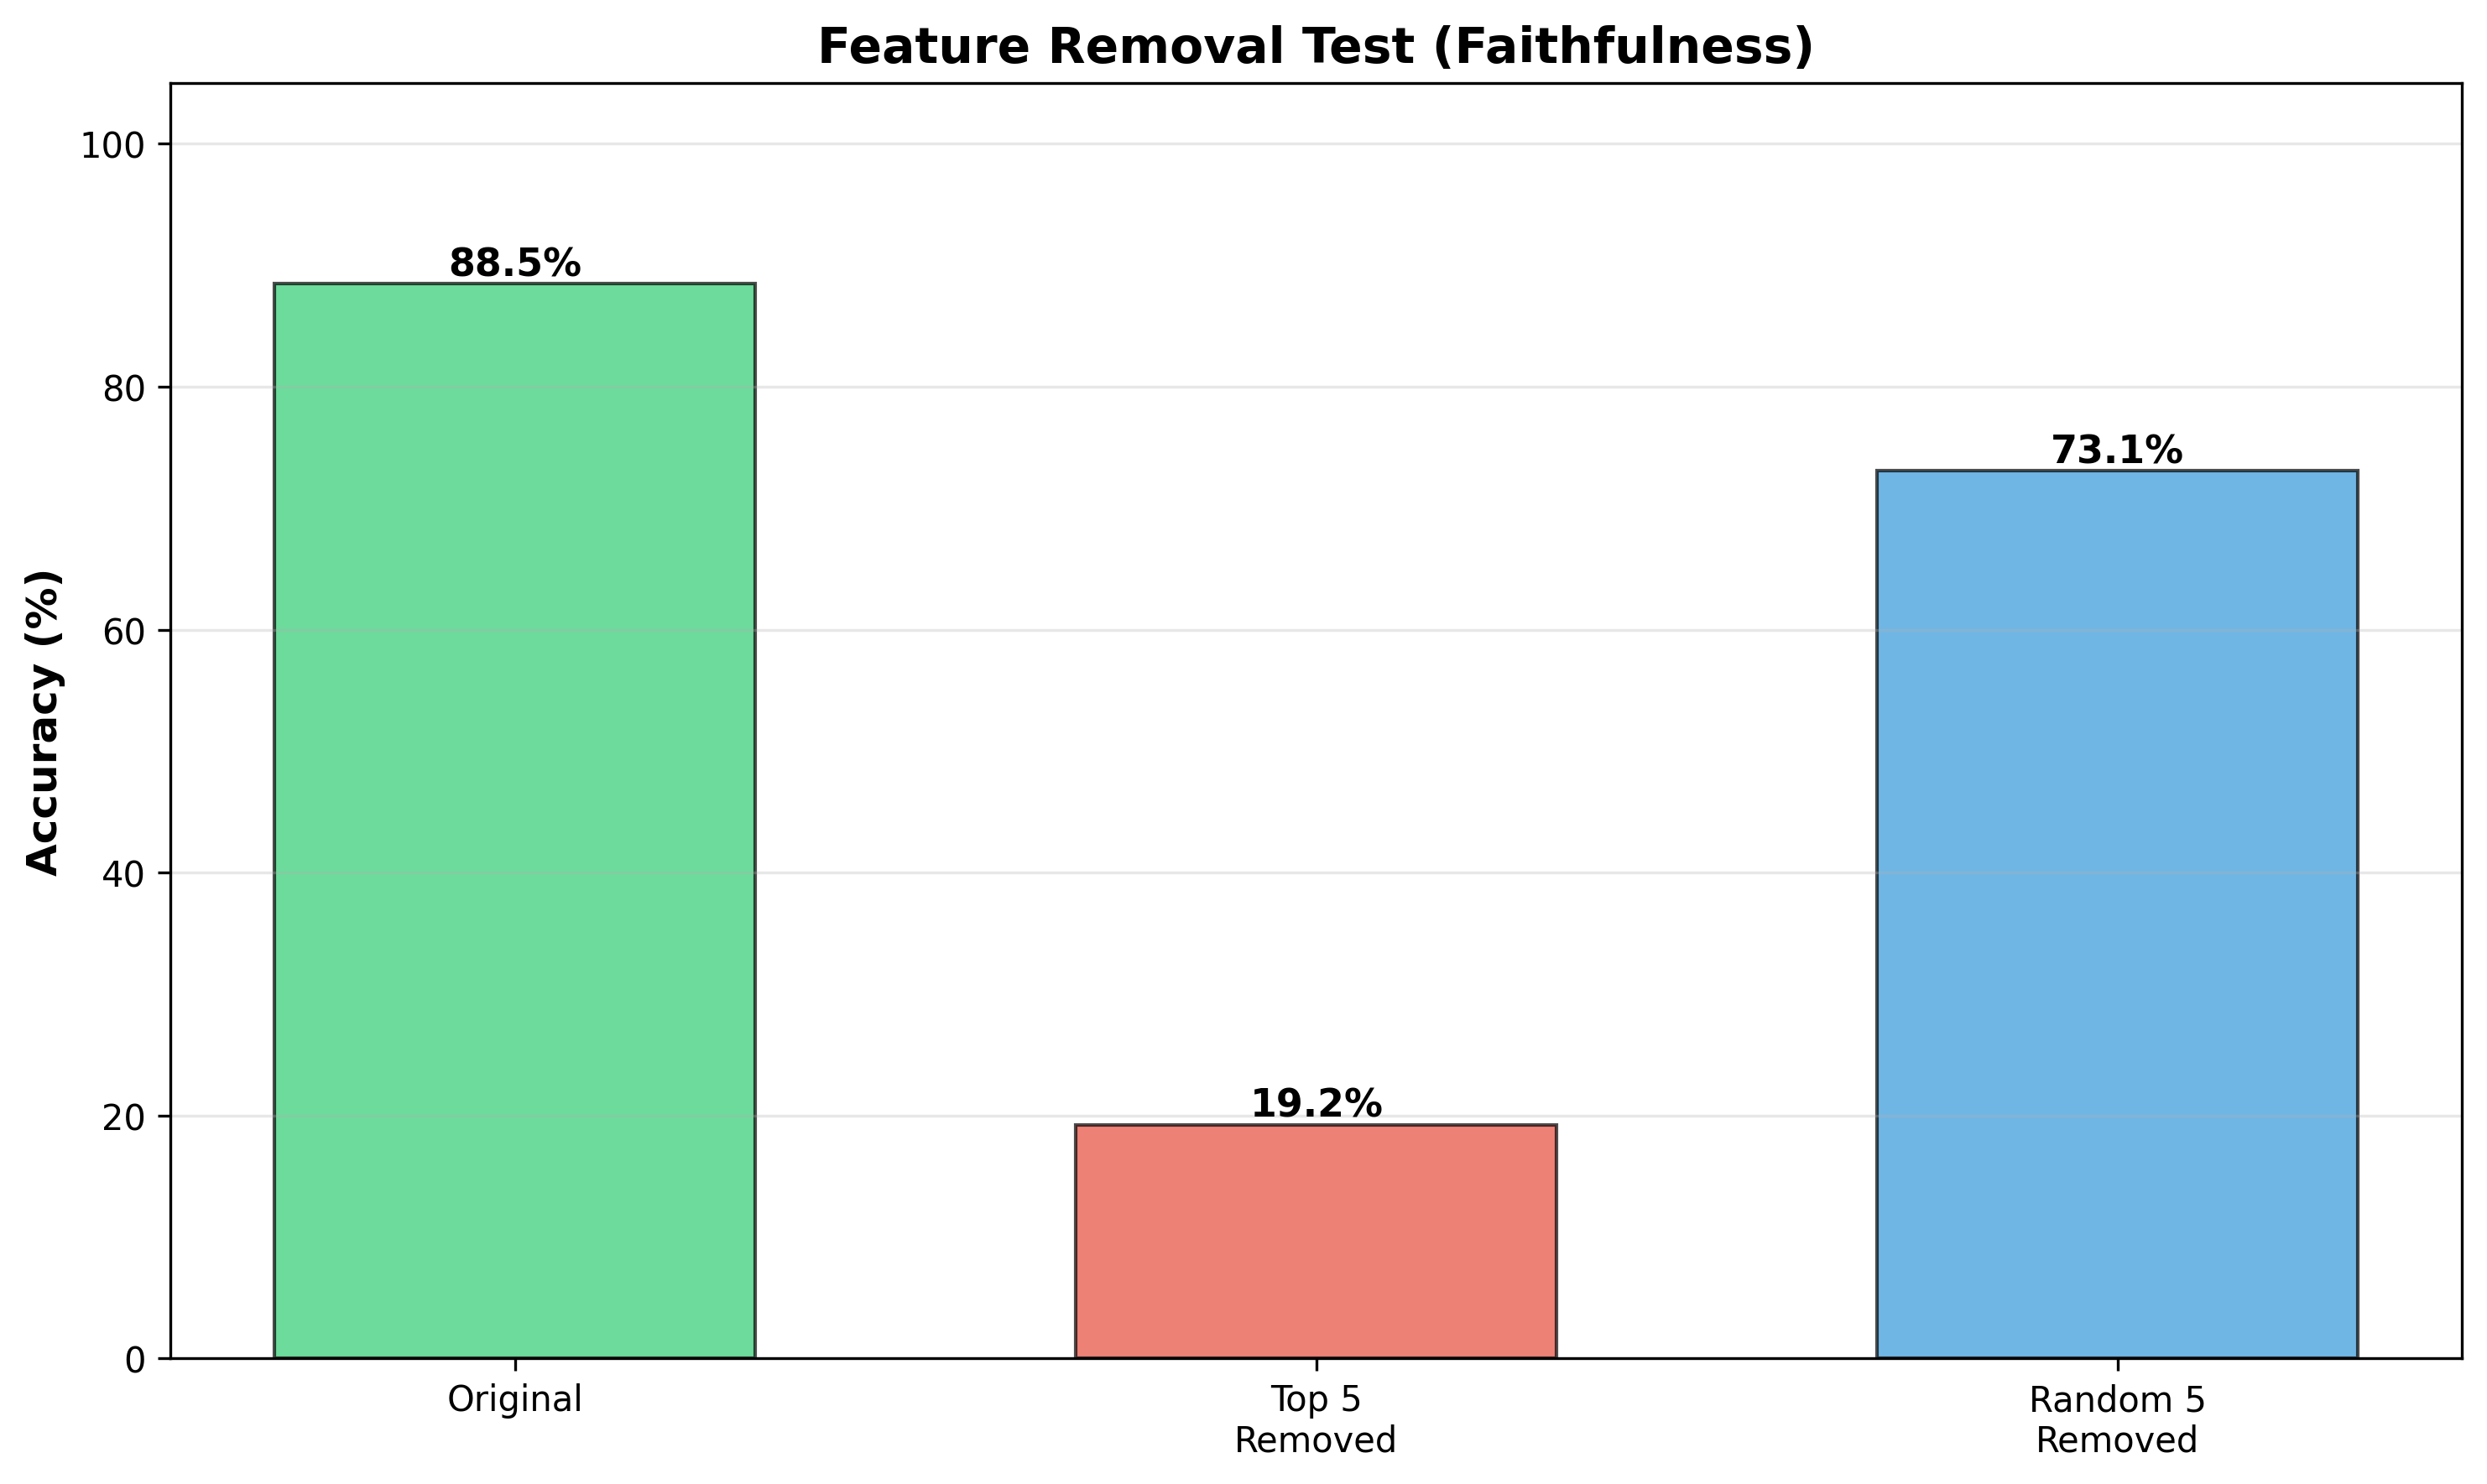

In [ ]:
display(Image(filename="../results/xai_evaluation/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_feature_removal_test.png"))

This graph clearly shows that the top 5 features are the most important. If we remove 5 at random the accuracy doesn't suffer a lot, but removing the top 5 produces a drastic drop in accuracy. With these graphs, it looks clear that the explanations by SHAP are robust.

Lastly, I added noise to some features to confirm the robustness. The results are the following:

<!-- <img src="../results/xai_evaluation/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_noise_test.png" width="700"> -->


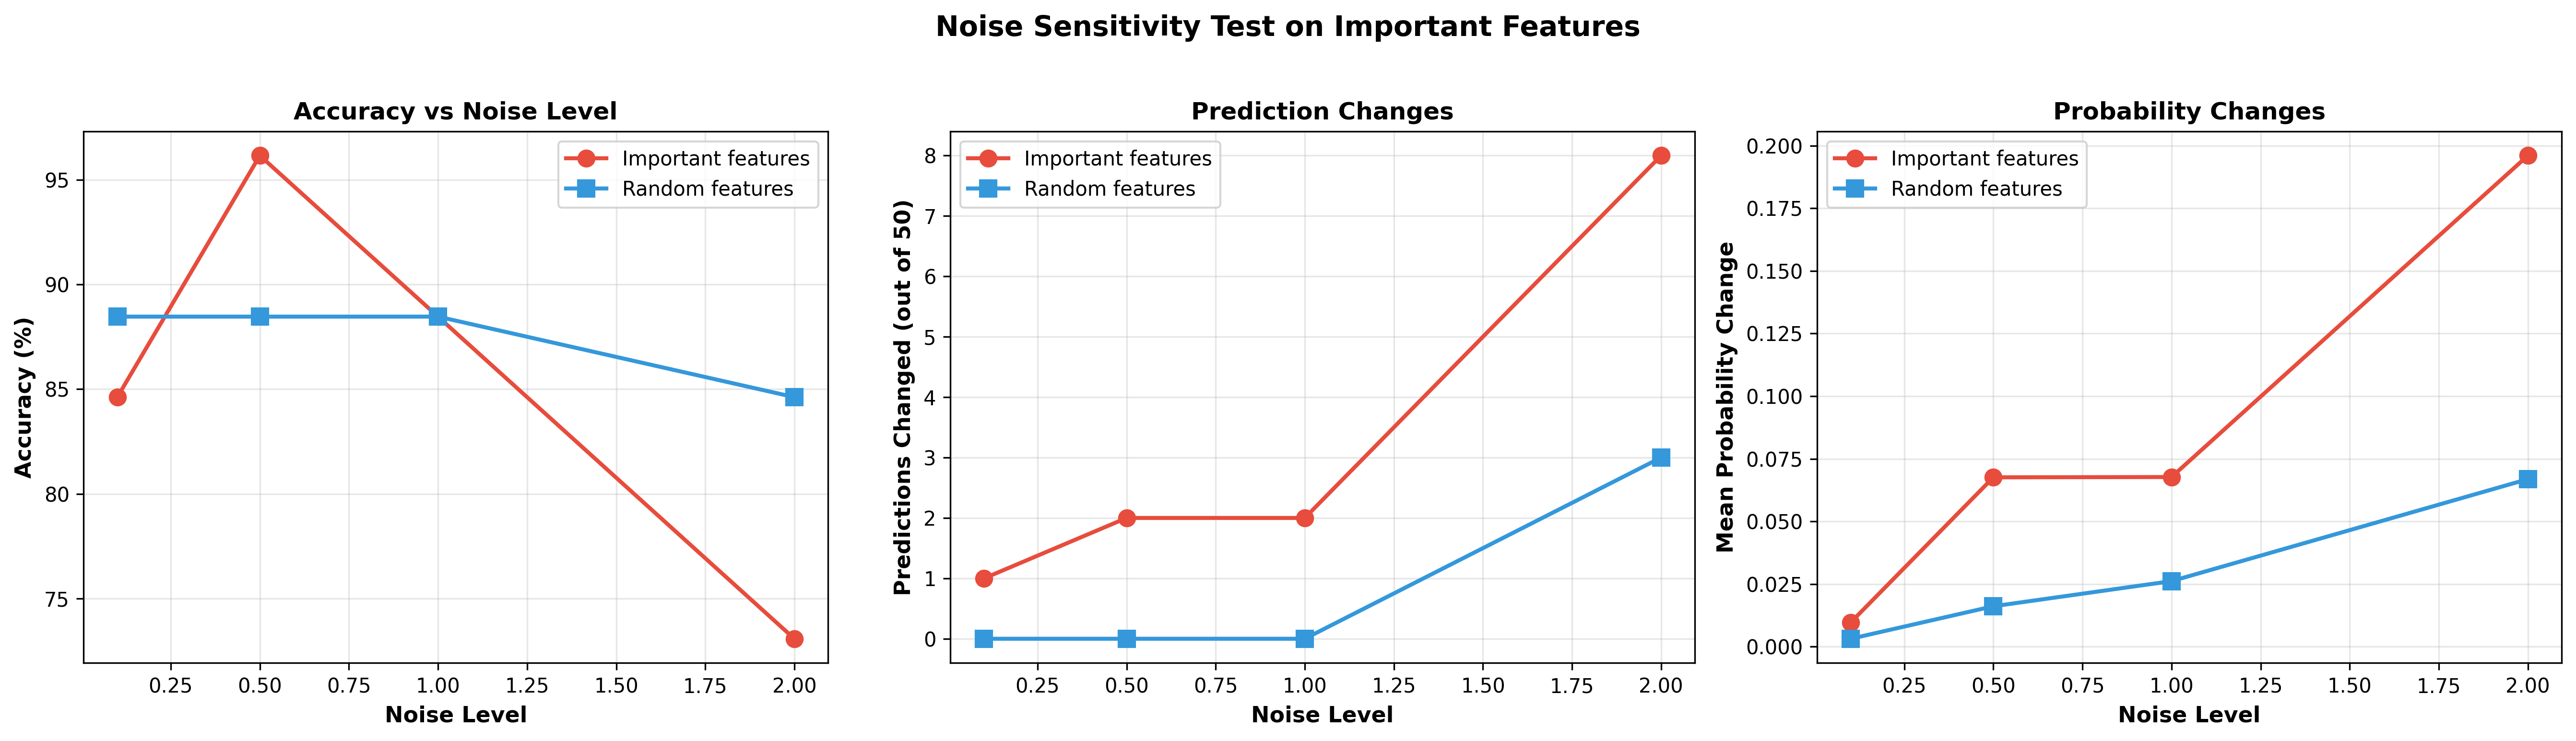

In [ ]:
display(Image(filename="../results/xai_evaluation/Tab_model_lr_0.0001_bs_8_hd_(128, 256)_dropout_0.2_encode_True_drop_True_cw_True_1.5_noise_test.png"))

These graphs show how the accuracy, predictions and probabilities change when I add noise to the features (the important ones and some chosen at random).
The accuracy does something weird, with a noise of 0.5, the accuracy drastically improves. I think this is because of random effects in the small sample set or because adding noise sometimes pushes features toward values that are more favorable for correct predictions. Nevertheless, when adding a lot of noise to important features, the accuracy drops sharply.
The predicions and probability changes are more consistent. If we add noise to important features more predictions change and the variations in probability are greater.